In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device='cuda:1'

In [4]:
def gen_data():
    bins = [np.linspace(-7,7,41)]*2
    _ed = np.linspace(-7,7,41)
    _ct = _ed[:-1] + np.diff(_ed)/2
    grid = np.meshgrid(*[_ct]*2, indexing='ij')

    
    K = 2
    centers = np.random.uniform(-6,6, size = (K, 2))
    X = np.concatenate([np.random.multivariate_normal(cc,0.2*np.eye(2), size = (1000,)) for cc in centers])
    c,_,_= np.histogram2d(X[:,0], X[:,1], bins = bins)
    c = np.log(c + 1e-2)
    c = np.stack([grid[0],grid[1],1-grid[0],1-grid[1],c])
    return torch.FloatTensor(c)[None,:], torch.FloatTensor(centers)[None,:]

def make_batch(
        Nbatch = 34,
        data_mean = torch.FloatTensor([0,0,0,0,3]),
        data_std = torch.FloatTensor([1,1,1,1,1])
    ):
    batch = [gen_data() for i in range(Nbatch)]
    data = torch.concat([b[0] for b in batch])
    trgt = torch.concat([b[1] for b in batch])
    
    bkgtrgt = -3*torch.ones(Nbatch,1,2)
    return data.to(device), trgt.to(device)
make_batch(123)[0].shape

torch.Size([123, 5, 40, 40])

In [5]:
class TrivialSlotEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 2
                
        self.hidden_dim = 4
        self.encoder1 = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
        )
        self.encoder2 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(40*40*self.hidden_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,self.latent_dim)
        )   
        
    def forward(self, data):
        encoded_data = self.encoder1(data)
        positions = self.encoder2(encoded_data)
        positions = positions.unsqueeze(1)
        return positions

In [9]:
class SlotAttentionEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.k_slots = 3
        self.latent_dim = 32
        self.hidden_dim = 32
        self.query_dim = 32
        self.slot_dim = 32
        self.n_iter = 1

        self.queryN = torch.nn.LayerNorm(self.query_dim)
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.updateN = torch.nn.LayerNorm(self.query_dim)

        self.toK = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
        )   
        
        self.final = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.slot_dim)
        )

        self.updateff = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.query_dim)
        )
        
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(device)
        
        mu = torch.zeros(1,1,self.query_dim).to(device)
        logsigma = torch.zeros(1,1,self.query_dim).to(device)
        
        return mu + noise*logsigma.exp()


    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        att = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        att = torch.nn.functional.softmax(att, dim = 1)

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)        
        vals = self.toV(encoded_data)
        extracted = torch.einsum('bsd,bde->bse',wts,vals)
        
        extracted = self.gru(
            extracted.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return extracted.reshape(queries.shape)
        
    def forward(self, data):
        Nbatch = data.shape[0]
        queries = self.init_slots(Nbatch)
        encoded_data = self.encoder(data)
        queries = self.iterate(queries, encoded_data)
        queries = self.iterate(queries, encoded_data)
        positions = self.final(queries)
        return positions,queries
        
SlotAttentionEncoder().to(device)(torch.randn(123,5,40,40,device=device))[0].shape

torch.Size([123, 3, 32])

In [10]:
TrivialSlotEncoder().to(device)(torch.randn(123,5,40,40,device=device)).shape

torch.Size([123, 1, 2])

In [12]:
class AttModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 32

        self.encoder = SlotAttentionEncoder()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,40*40),
            torch.nn.Unflatten(-1,(40,40))
        )
        

    def forward(self, data):
        Nbatch, *_ = data.shape
        positions,queries = self.encoder(data)
        decoded = self.decoder(positions)
        reco = decoded.sum(dim = 1)
        return reco,queries,decoded

AttModel().to(device).encoder(make_batch(123)[0])[0].shape

torch.Size([123, 3, 32])

In [14]:
def plotit(batchidx, model, data, losses):
    with torch.no_grad():
        model.eval()
        pred,queries,decoded = model(data)
        encoded_data = model.encoder.encoder(data)
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = model.encoder.dataN(encoded_data)
        att,wts = model.encoder.attention_and_weights(queries,encoded_data)
#         print(wts.sum(dim=-1).max(),'max')
        att = att.reshape(len(att),3,40,40)
        wts = wts.reshape(len(att),3,40,40)
        
        crap = model.decoder(torch.randn(2,model.encoder.k_slots,model.encoder.slot_dim,device=device))
        
    f,axarr = plt.subplots(3,6)
    ax = axarr[0,0]
    ax.plot(losses)
    ax.set_yscale('log')
    ax.axis('off')
    ax = axarr[0,1]
    ax.pcolormesh(data[batchidx,-1].cpu(), vmin = -3, vmax = 3)
    ax.axis('off')
    ax = axarr[0,2]
    ax.pcolormesh(pred[batchidx].cpu(), vmin = -3, vmax = 3)
    ax.axis('off')
    for i in range(3):
        ax = axarr[0,3+i]
        ax.pcolormesh(att[batchidx,i].cpu(), vmin = 0, vmax = 1)
        ax.axis('off')
    for i in range(3):
        ax = axarr[1,3+i]
        print(wts.min(),wts.max(),'>>><<')
        ax.pcolormesh(wts[batchidx,i].cpu(), vmin = 0, vmax = .001)
        ax.axis('off')
    for i in range(3):
        ax = axarr[1,i]
        ax.axis('off')
        ax = axarr[2,i]
        ax.axis('off')
    ax = axarr[1,0]
    ax.pcolormesh(crap[batchidx,0].cpu())

    ax = axarr[1,2]
    ax.pcolormesh(decoded.sum(dim=1)[batchidx].cpu(), vmin = -3, vmax = 3)
    for i in range(3):
        ax = axarr[2,3+i]
        ax.pcolormesh(decoded[batchidx,i].cpu(), vmin = -3, vmax = 3)
        ax.axis('off')
    f.set_size_inches(6,3)
    plt.show()    

def train(model, Ntrain = 5000):
    opt = torch.optim.Adam(model.parameters(), 3e-4)
    model.train()
    losses = []
    for i in range(Ntrain):
        
        warmup_steps = 5000
        learning_rate = 3e-4
        if i < warmup_steps:
            learning_rate = learning_rate * (i / warmup_steps)
        else:
            learning_rate = learning_rate
        opt.param_groups[0]['lr'] = learning_rate

        
        data, trgt = make_batch(4)
        pred,*_ = model(data)
        loss = torch.nn.functional.mse_loss(
            data[:,-1,...],
            pred
        )
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        if i % 250 == 0:
            print('loss',i,loss,opt.param_groups[0]['lr'])
            plotit(0,model,data,losses)
            plotit(1,model,data,losses)

    model.eval()
    return model,losses

loss 0 tensor(20.2657, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0
tensor(6.5162e-08, device='cuda:1') tensor(0.0047, device='cuda:1') >>><<
tensor(6.5162e-08, device='cuda:1') tensor(0.0047, device='cuda:1') >>><<
tensor(6.5162e-08, device='cuda:1') tensor(0.0047, device='cuda:1') >>><<


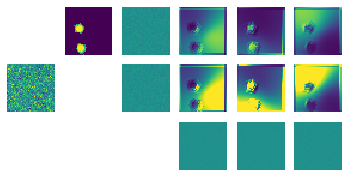

tensor(9.8160e-08, device='cuda:1') tensor(0.0036, device='cuda:1') >>><<
tensor(9.8160e-08, device='cuda:1') tensor(0.0036, device='cuda:1') >>><<
tensor(9.8160e-08, device='cuda:1') tensor(0.0036, device='cuda:1') >>><<


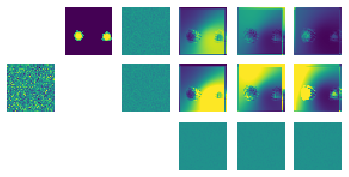

loss 250 tensor(19.6117, device='cuda:1', grad_fn=<MseLossBackward0>) 1.4999999999999999e-05
tensor(1.4116e-08, device='cuda:1') tensor(0.0042, device='cuda:1') >>><<
tensor(1.4116e-08, device='cuda:1') tensor(0.0042, device='cuda:1') >>><<
tensor(1.4116e-08, device='cuda:1') tensor(0.0042, device='cuda:1') >>><<


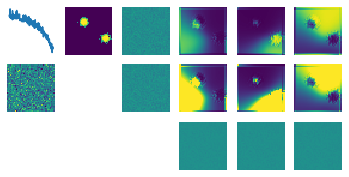

tensor(2.2038e-07, device='cuda:1') tensor(0.0148, device='cuda:1') >>><<
tensor(2.2038e-07, device='cuda:1') tensor(0.0148, device='cuda:1') >>><<
tensor(2.2038e-07, device='cuda:1') tensor(0.0148, device='cuda:1') >>><<


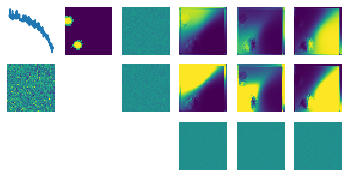

loss 500 tensor(3.5682, device='cuda:1', grad_fn=<MseLossBackward0>) 2.9999999999999997e-05
tensor(2.4087e-08, device='cuda:1') tensor(0.0119, device='cuda:1') >>><<
tensor(2.4087e-08, device='cuda:1') tensor(0.0119, device='cuda:1') >>><<
tensor(2.4087e-08, device='cuda:1') tensor(0.0119, device='cuda:1') >>><<


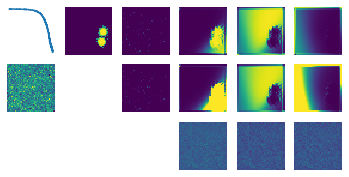

tensor(1.6066e-08, device='cuda:1') tensor(0.0094, device='cuda:1') >>><<
tensor(1.6066e-08, device='cuda:1') tensor(0.0094, device='cuda:1') >>><<
tensor(1.6066e-08, device='cuda:1') tensor(0.0094, device='cuda:1') >>><<


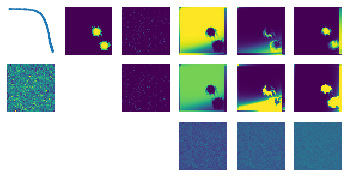

loss 750 tensor(2.9590, device='cuda:1', grad_fn=<MseLossBackward0>) 4.4999999999999996e-05
tensor(2.1720e-08, device='cuda:1') tensor(0.0261, device='cuda:1') >>><<
tensor(2.1720e-08, device='cuda:1') tensor(0.0261, device='cuda:1') >>><<
tensor(2.1720e-08, device='cuda:1') tensor(0.0261, device='cuda:1') >>><<


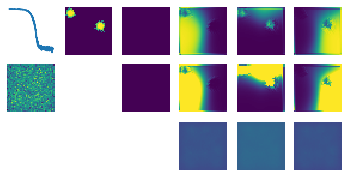

tensor(4.5733e-08, device='cuda:1') tensor(0.0035, device='cuda:1') >>><<
tensor(4.5733e-08, device='cuda:1') tensor(0.0035, device='cuda:1') >>><<
tensor(4.5733e-08, device='cuda:1') tensor(0.0035, device='cuda:1') >>><<


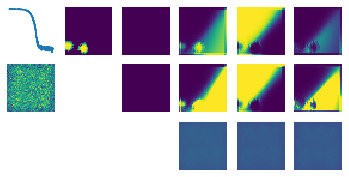

loss 1000 tensor(2.9175, device='cuda:1', grad_fn=<MseLossBackward0>) 5.9999999999999995e-05
tensor(1.4047e-08, device='cuda:1') tensor(0.0063, device='cuda:1') >>><<
tensor(1.4047e-08, device='cuda:1') tensor(0.0063, device='cuda:1') >>><<
tensor(1.4047e-08, device='cuda:1') tensor(0.0063, device='cuda:1') >>><<


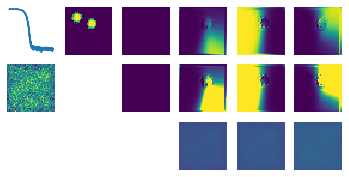

tensor(1.0806e-08, device='cuda:1') tensor(0.0044, device='cuda:1') >>><<
tensor(1.0806e-08, device='cuda:1') tensor(0.0044, device='cuda:1') >>><<
tensor(1.0806e-08, device='cuda:1') tensor(0.0044, device='cuda:1') >>><<


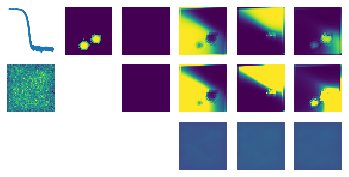

loss 1250 tensor(2.9725, device='cuda:1', grad_fn=<MseLossBackward0>) 7.5e-05
tensor(1.1106e-08, device='cuda:1') tensor(0.0063, device='cuda:1') >>><<
tensor(1.1106e-08, device='cuda:1') tensor(0.0063, device='cuda:1') >>><<
tensor(1.1106e-08, device='cuda:1') tensor(0.0063, device='cuda:1') >>><<


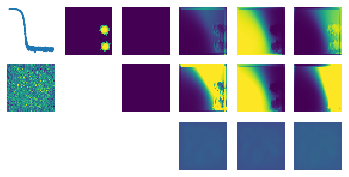

tensor(1.0272e-08, device='cuda:1') tensor(0.0065, device='cuda:1') >>><<
tensor(1.0272e-08, device='cuda:1') tensor(0.0065, device='cuda:1') >>><<
tensor(1.0272e-08, device='cuda:1') tensor(0.0065, device='cuda:1') >>><<


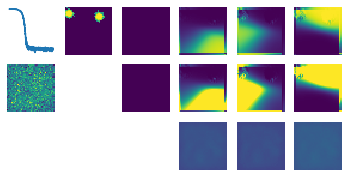

loss 1500 tensor(2.7356, device='cuda:1', grad_fn=<MseLossBackward0>) 8.999999999999999e-05
tensor(1.9182e-08, device='cuda:1') tensor(0.0037, device='cuda:1') >>><<
tensor(1.9182e-08, device='cuda:1') tensor(0.0037, device='cuda:1') >>><<
tensor(1.9182e-08, device='cuda:1') tensor(0.0037, device='cuda:1') >>><<


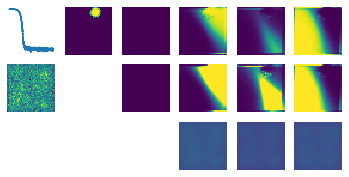

tensor(1.5330e-08, device='cuda:1') tensor(0.0052, device='cuda:1') >>><<
tensor(1.5330e-08, device='cuda:1') tensor(0.0052, device='cuda:1') >>><<
tensor(1.5330e-08, device='cuda:1') tensor(0.0052, device='cuda:1') >>><<


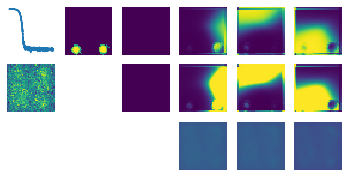

loss 1750 tensor(2.8714, device='cuda:1', grad_fn=<MseLossBackward0>) 0.00010499999999999999
tensor(2.2900e-07, device='cuda:1') tensor(0.0031, device='cuda:1') >>><<
tensor(2.2900e-07, device='cuda:1') tensor(0.0031, device='cuda:1') >>><<
tensor(2.2900e-07, device='cuda:1') tensor(0.0031, device='cuda:1') >>><<


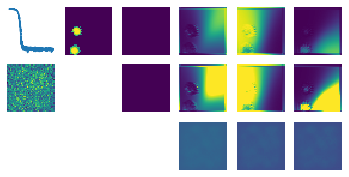

tensor(1.3009e-07, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(1.3009e-07, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(1.3009e-07, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<


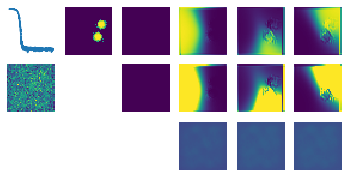

loss 2000 tensor(2.8003, device='cuda:1', grad_fn=<MseLossBackward0>) 0.00011999999999999999
tensor(2.5742e-07, device='cuda:1') tensor(0.0032, device='cuda:1') >>><<
tensor(2.5742e-07, device='cuda:1') tensor(0.0032, device='cuda:1') >>><<
tensor(2.5742e-07, device='cuda:1') tensor(0.0032, device='cuda:1') >>><<


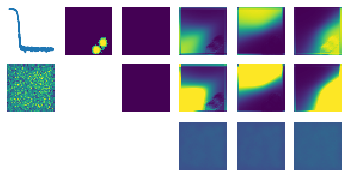

tensor(1.2589e-08, device='cuda:1') tensor(0.0114, device='cuda:1') >>><<
tensor(1.2589e-08, device='cuda:1') tensor(0.0114, device='cuda:1') >>><<
tensor(1.2589e-08, device='cuda:1') tensor(0.0114, device='cuda:1') >>><<


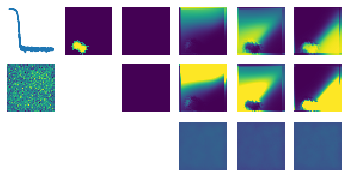

loss 2250 tensor(2.8411, device='cuda:1', grad_fn=<MseLossBackward0>) 0.000135
tensor(1.0411e-08, device='cuda:1') tensor(0.0035, device='cuda:1') >>><<
tensor(1.0411e-08, device='cuda:1') tensor(0.0035, device='cuda:1') >>><<
tensor(1.0411e-08, device='cuda:1') tensor(0.0035, device='cuda:1') >>><<


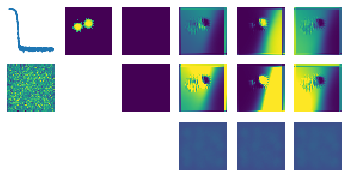

tensor(2.1744e-07, device='cuda:1') tensor(0.0042, device='cuda:1') >>><<
tensor(2.1744e-07, device='cuda:1') tensor(0.0042, device='cuda:1') >>><<
tensor(2.1744e-07, device='cuda:1') tensor(0.0042, device='cuda:1') >>><<


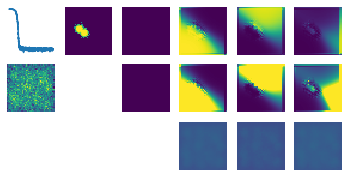

loss 2500 tensor(2.8839, device='cuda:1', grad_fn=<MseLossBackward0>) 0.00015
tensor(5.5890e-08, device='cuda:1') tensor(0.0030, device='cuda:1') >>><<
tensor(5.5890e-08, device='cuda:1') tensor(0.0030, device='cuda:1') >>><<
tensor(5.5890e-08, device='cuda:1') tensor(0.0030, device='cuda:1') >>><<


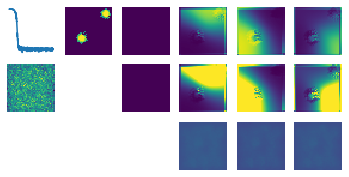

tensor(1.2615e-07, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(1.2615e-07, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(1.2615e-07, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<


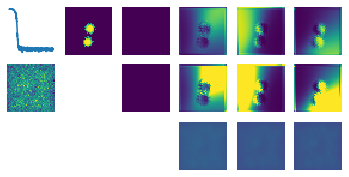

loss 2750 tensor(2.8285, device='cuda:1', grad_fn=<MseLossBackward0>) 0.000165
tensor(1.2470e-07, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<
tensor(1.2470e-07, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<
tensor(1.2470e-07, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<


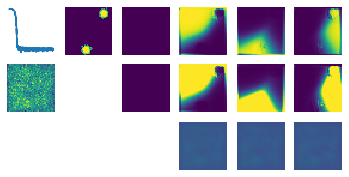

tensor(1.7126e-07, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<
tensor(1.7126e-07, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<
tensor(1.7126e-07, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<


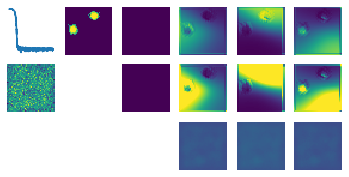

loss 3000 tensor(2.8797, device='cuda:1', grad_fn=<MseLossBackward0>) 0.00017999999999999998
tensor(1.8113e-07, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<
tensor(1.8113e-07, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<
tensor(1.8113e-07, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<


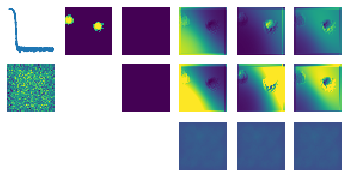

tensor(1.5672e-08, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<
tensor(1.5672e-08, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<
tensor(1.5672e-08, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<


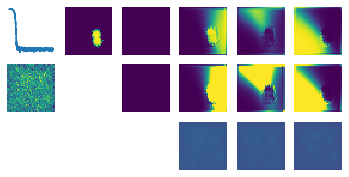

loss 3250 tensor(2.8903, device='cuda:1', grad_fn=<MseLossBackward0>) 0.000195
tensor(1.3133e-08, device='cuda:1') tensor(0.0068, device='cuda:1') >>><<
tensor(1.3133e-08, device='cuda:1') tensor(0.0068, device='cuda:1') >>><<
tensor(1.3133e-08, device='cuda:1') tensor(0.0068, device='cuda:1') >>><<


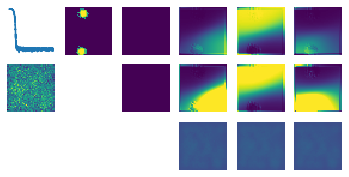

tensor(1.0213e-07, device='cuda:1') tensor(0.0028, device='cuda:1') >>><<
tensor(1.0213e-07, device='cuda:1') tensor(0.0028, device='cuda:1') >>><<
tensor(1.0213e-07, device='cuda:1') tensor(0.0028, device='cuda:1') >>><<


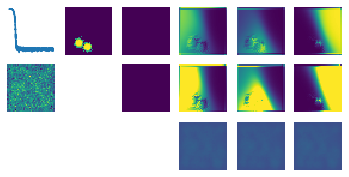

loss 3500 tensor(2.9166, device='cuda:1', grad_fn=<MseLossBackward0>) 0.00020999999999999998
tensor(3.4936e-08, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<
tensor(3.4936e-08, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<
tensor(3.4936e-08, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<


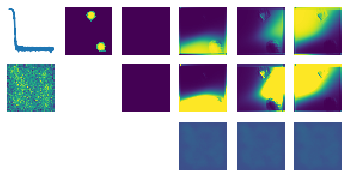

tensor(2.5617e-07, device='cuda:1') tensor(0.0025, device='cuda:1') >>><<
tensor(2.5617e-07, device='cuda:1') tensor(0.0025, device='cuda:1') >>><<
tensor(2.5617e-07, device='cuda:1') tensor(0.0025, device='cuda:1') >>><<


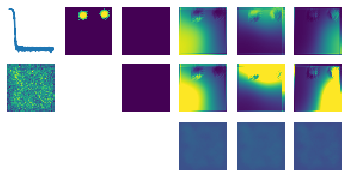

loss 3750 tensor(2.8318, device='cuda:1', grad_fn=<MseLossBackward0>) 0.000225
tensor(1.4246e-07, device='cuda:1') tensor(0.0031, device='cuda:1') >>><<
tensor(1.4246e-07, device='cuda:1') tensor(0.0031, device='cuda:1') >>><<
tensor(1.4246e-07, device='cuda:1') tensor(0.0031, device='cuda:1') >>><<


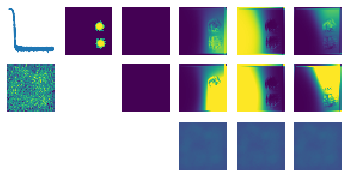

tensor(9.8298e-08, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(9.8298e-08, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(9.8298e-08, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<


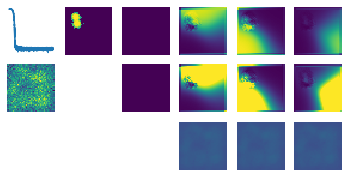

loss 4000 tensor(2.8021, device='cuda:1', grad_fn=<MseLossBackward0>) 0.00023999999999999998
tensor(2.2755e-06, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<
tensor(2.2755e-06, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<
tensor(2.2755e-06, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<


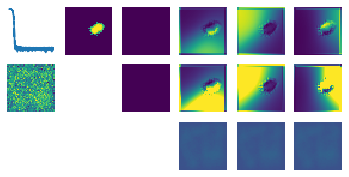

tensor(3.3594e-07, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(3.3594e-07, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(3.3594e-07, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<


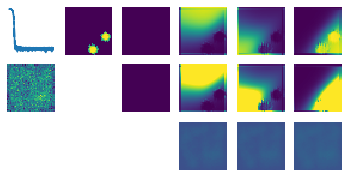

loss 4250 tensor(2.7316, device='cuda:1', grad_fn=<MseLossBackward0>) 0.00025499999999999996
tensor(5.9702e-07, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<
tensor(5.9702e-07, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<
tensor(5.9702e-07, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<


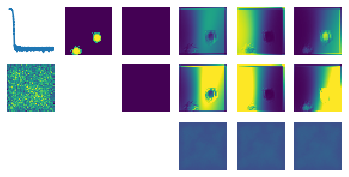

tensor(3.1187e-07, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(3.1187e-07, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(3.1187e-07, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<


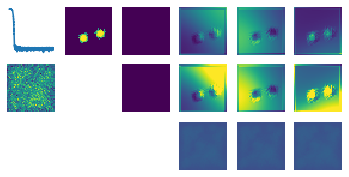

loss 4500 tensor(2.9515, device='cuda:1', grad_fn=<MseLossBackward0>) 0.00027
tensor(7.1510e-08, device='cuda:1') tensor(0.0031, device='cuda:1') >>><<
tensor(7.1510e-08, device='cuda:1') tensor(0.0031, device='cuda:1') >>><<
tensor(7.1510e-08, device='cuda:1') tensor(0.0031, device='cuda:1') >>><<


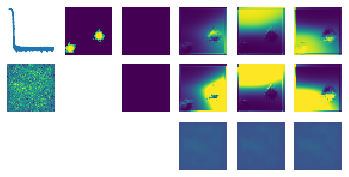

tensor(4.6984e-08, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<
tensor(4.6984e-08, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<
tensor(4.6984e-08, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<


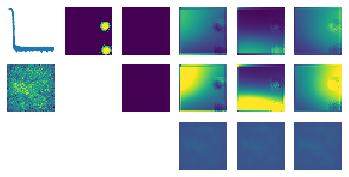

loss 4750 tensor(2.8231, device='cuda:1', grad_fn=<MseLossBackward0>) 0.000285
tensor(1.7835e-07, device='cuda:1') tensor(0.0026, device='cuda:1') >>><<
tensor(1.7835e-07, device='cuda:1') tensor(0.0026, device='cuda:1') >>><<
tensor(1.7835e-07, device='cuda:1') tensor(0.0026, device='cuda:1') >>><<


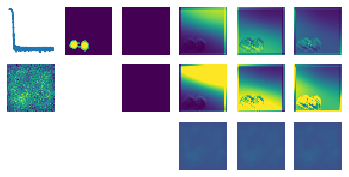

tensor(3.9232e-07, device='cuda:1') tensor(0.0041, device='cuda:1') >>><<
tensor(3.9232e-07, device='cuda:1') tensor(0.0041, device='cuda:1') >>><<
tensor(3.9232e-07, device='cuda:1') tensor(0.0041, device='cuda:1') >>><<


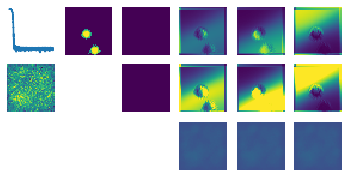

loss 5000 tensor(2.8845, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.4516e-08, device='cuda:1') tensor(0.0025, device='cuda:1') >>><<
tensor(1.4516e-08, device='cuda:1') tensor(0.0025, device='cuda:1') >>><<
tensor(1.4516e-08, device='cuda:1') tensor(0.0025, device='cuda:1') >>><<


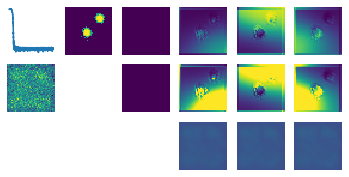

tensor(1.5109e-06, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<
tensor(1.5109e-06, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<
tensor(1.5109e-06, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<


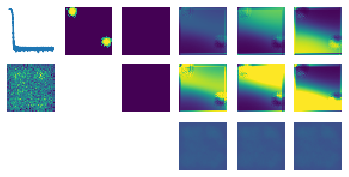

loss 5250 tensor(2.8832, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(4.7537e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(4.7537e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(4.7537e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<


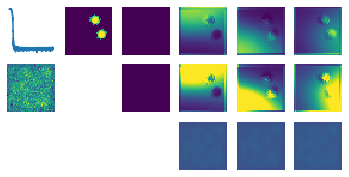

tensor(1.2175e-06, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<
tensor(1.2175e-06, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<
tensor(1.2175e-06, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<


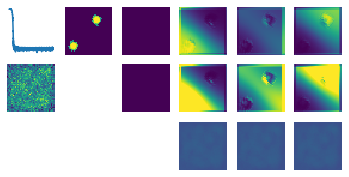

loss 5500 tensor(2.9451, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(3.7056e-07, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<
tensor(3.7056e-07, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<
tensor(3.7056e-07, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<


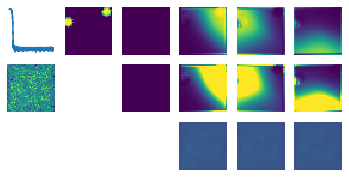

tensor(1.0234e-07, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(1.0234e-07, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(1.0234e-07, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<


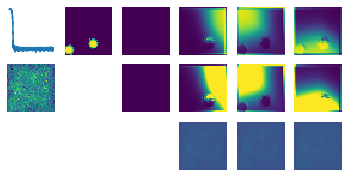

loss 5750 tensor(2.7202, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.1328e-05, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(1.1328e-05, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(1.1328e-05, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<


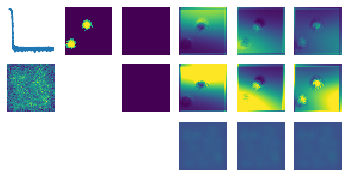

tensor(1.8275e-06, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(1.8275e-06, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(1.8275e-06, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<


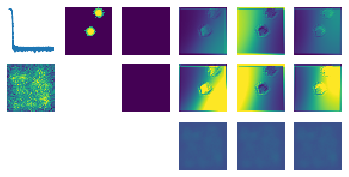

loss 6000 tensor(2.7932, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(2.9298e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(2.9298e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(2.9298e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<


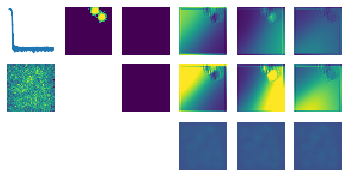

tensor(2.7398e-06, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(2.7398e-06, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(2.7398e-06, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<


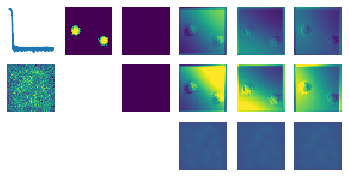

loss 6250 tensor(2.9100, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(5.7091e-06, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<
tensor(5.7091e-06, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<
tensor(5.7091e-06, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<


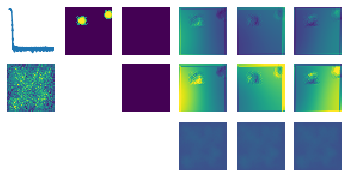

tensor(3.0583e-07, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<
tensor(3.0583e-07, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<
tensor(3.0583e-07, device='cuda:1') tensor(0.0033, device='cuda:1') >>><<


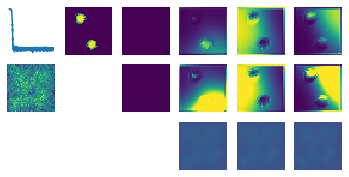

loss 6500 tensor(2.9551, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.8255e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(1.8255e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(1.8255e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<


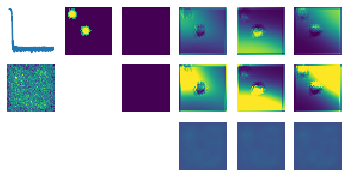

tensor(2.4432e-06, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<
tensor(2.4432e-06, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<
tensor(2.4432e-06, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<


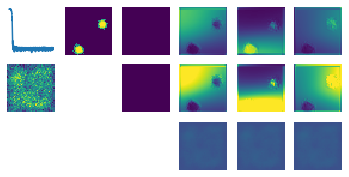

loss 6750 tensor(2.9827, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(3.0038e-06, device='cuda:1') tensor(0.0019, device='cuda:1') >>><<
tensor(3.0038e-06, device='cuda:1') tensor(0.0019, device='cuda:1') >>><<
tensor(3.0038e-06, device='cuda:1') tensor(0.0019, device='cuda:1') >>><<


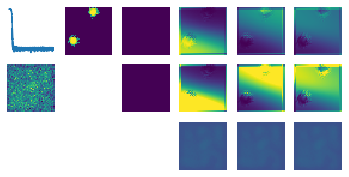

tensor(2.0194e-05, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<
tensor(2.0194e-05, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<
tensor(2.0194e-05, device='cuda:1') tensor(0.0021, device='cuda:1') >>><<


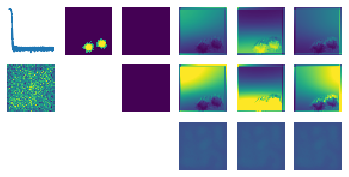

loss 7000 tensor(2.8679, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.3817e-05, device='cuda:1') tensor(0.0019, device='cuda:1') >>><<
tensor(1.3817e-05, device='cuda:1') tensor(0.0019, device='cuda:1') >>><<
tensor(1.3817e-05, device='cuda:1') tensor(0.0019, device='cuda:1') >>><<


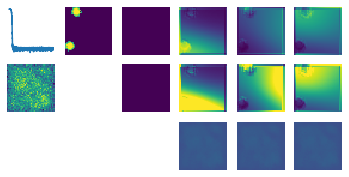

tensor(3.0986e-05, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<
tensor(3.0986e-05, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<
tensor(3.0986e-05, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<


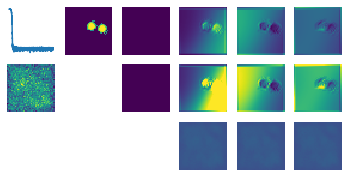

loss 7250 tensor(2.9078, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.3398e-06, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<
tensor(1.3398e-06, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<
tensor(1.3398e-06, device='cuda:1') tensor(0.0022, device='cuda:1') >>><<


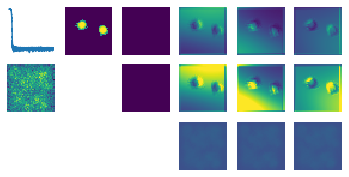

tensor(1.7553e-05, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(1.7553e-05, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(1.7553e-05, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<


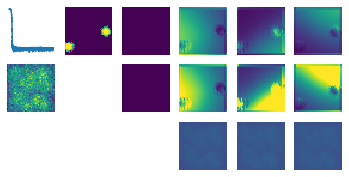

loss 7500 tensor(2.8644, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(9.5118e-06, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(9.5118e-06, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(9.5118e-06, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<


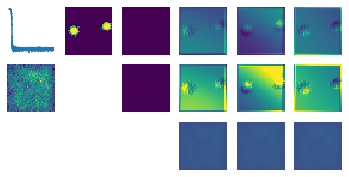

tensor(9.0655e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(9.0655e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<
tensor(9.0655e-07, device='cuda:1') tensor(0.0020, device='cuda:1') >>><<


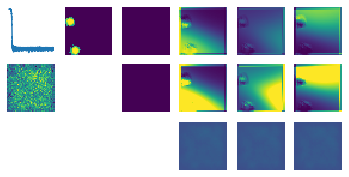

loss 7750 tensor(2.7370, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(3.0932e-05, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(3.0932e-05, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<
tensor(3.0932e-05, device='cuda:1') tensor(0.0024, device='cuda:1') >>><<


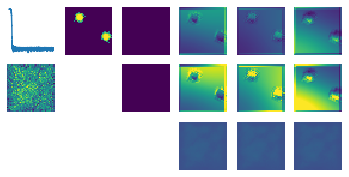

tensor(5.4847e-06, device='cuda:1') tensor(0.0018, device='cuda:1') >>><<
tensor(5.4847e-06, device='cuda:1') tensor(0.0018, device='cuda:1') >>><<
tensor(5.4847e-06, device='cuda:1') tensor(0.0018, device='cuda:1') >>><<


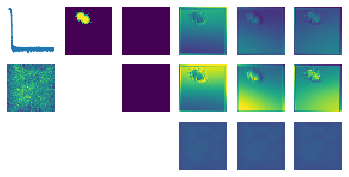

loss 8000 tensor(2.8463, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(2.5301e-05, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<
tensor(2.5301e-05, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<
tensor(2.5301e-05, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<


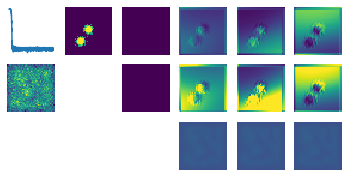

tensor(3.4057e-05, device='cuda:1') tensor(0.0019, device='cuda:1') >>><<
tensor(3.4057e-05, device='cuda:1') tensor(0.0019, device='cuda:1') >>><<
tensor(3.4057e-05, device='cuda:1') tensor(0.0019, device='cuda:1') >>><<


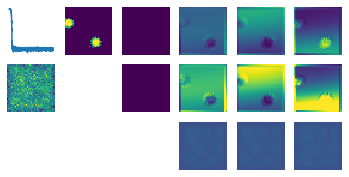

loss 8250 tensor(2.9404, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(8.1840e-06, device='cuda:1') tensor(0.0025, device='cuda:1') >>><<
tensor(8.1840e-06, device='cuda:1') tensor(0.0025, device='cuda:1') >>><<
tensor(8.1840e-06, device='cuda:1') tensor(0.0025, device='cuda:1') >>><<


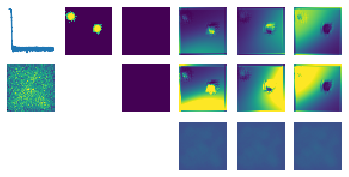

tensor(5.1200e-06, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<
tensor(5.1200e-06, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<
tensor(5.1200e-06, device='cuda:1') tensor(0.0023, device='cuda:1') >>><<


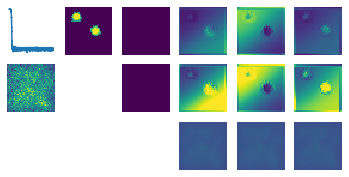

loss 8500 tensor(2.9397, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.8244e-05, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(1.8244e-05, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<
tensor(1.8244e-05, device='cuda:1') tensor(0.0027, device='cuda:1') >>><<


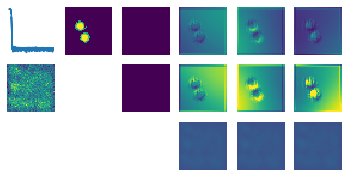

tensor(3.6185e-06, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<
tensor(3.6185e-06, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<
tensor(3.6185e-06, device='cuda:1') tensor(0.0029, device='cuda:1') >>><<


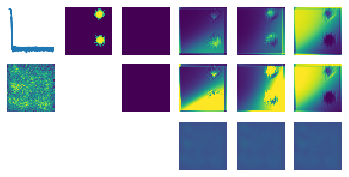

loss 8750 tensor(2.8476, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(5.2284e-07, device='cuda:1') tensor(0.0035, device='cuda:1') >>><<
tensor(5.2284e-07, device='cuda:1') tensor(0.0035, device='cuda:1') >>><<
tensor(5.2284e-07, device='cuda:1') tensor(0.0035, device='cuda:1') >>><<


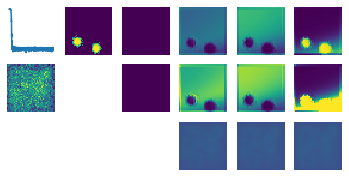

tensor(1.7971e-07, device='cuda:1') tensor(0.0041, device='cuda:1') >>><<
tensor(1.7971e-07, device='cuda:1') tensor(0.0041, device='cuda:1') >>><<
tensor(1.7971e-07, device='cuda:1') tensor(0.0041, device='cuda:1') >>><<


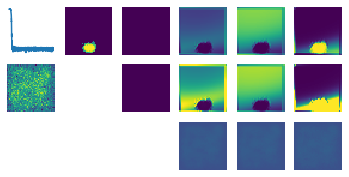

loss 9000 tensor(2.8673, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0035e-08, device='cuda:1') tensor(0.0073, device='cuda:1') >>><<
tensor(1.0035e-08, device='cuda:1') tensor(0.0073, device='cuda:1') >>><<
tensor(1.0035e-08, device='cuda:1') tensor(0.0073, device='cuda:1') >>><<


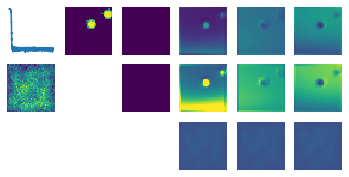

tensor(1.0060e-08, device='cuda:1') tensor(0.0067, device='cuda:1') >>><<
tensor(1.0060e-08, device='cuda:1') tensor(0.0067, device='cuda:1') >>><<
tensor(1.0060e-08, device='cuda:1') tensor(0.0067, device='cuda:1') >>><<


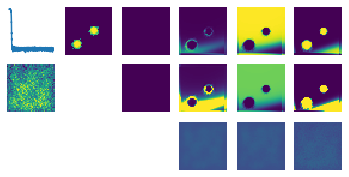

loss 9250 tensor(2.8589, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0081, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0081, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0081, device='cuda:1') >>><<


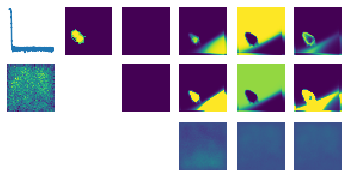

tensor(1.0000e-08, device='cuda:1') tensor(0.0068, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0068, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0068, device='cuda:1') >>><<


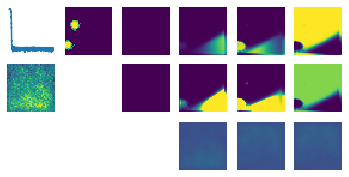

loss 9500 tensor(2.7555, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0079, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0079, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0079, device='cuda:1') >>><<


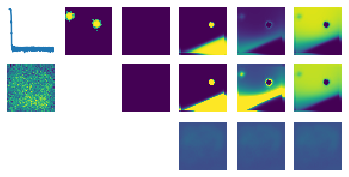

tensor(1.0000e-08, device='cuda:1') tensor(0.0085, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0085, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0085, device='cuda:1') >>><<


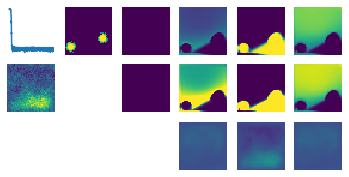

loss 9750 tensor(2.8599, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0172, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0172, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0172, device='cuda:1') >>><<


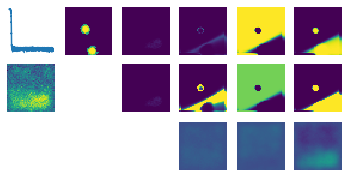

tensor(1.0000e-08, device='cuda:1') tensor(0.0156, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0156, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0156, device='cuda:1') >>><<


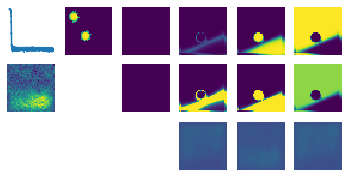

loss 10000 tensor(2.7512, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0100, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0100, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0100, device='cuda:1') >>><<


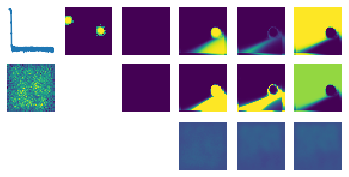

tensor(1.0000e-08, device='cuda:1') tensor(0.0103, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0103, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0103, device='cuda:1') >>><<


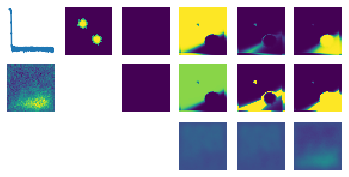

loss 10250 tensor(2.9300, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0102, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0102, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0102, device='cuda:1') >>><<


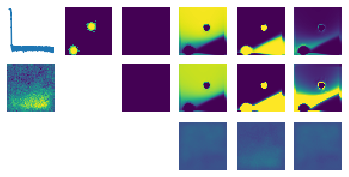

tensor(1.0000e-08, device='cuda:1') tensor(0.0101, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0101, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0101, device='cuda:1') >>><<


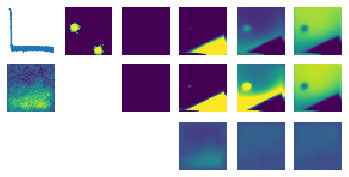

loss 10500 tensor(2.7541, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0113, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0113, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0113, device='cuda:1') >>><<


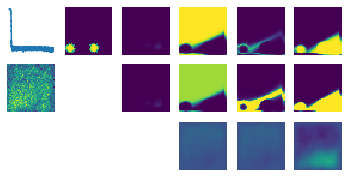

tensor(1.0000e-08, device='cuda:1') tensor(0.0108, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0108, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0108, device='cuda:1') >>><<


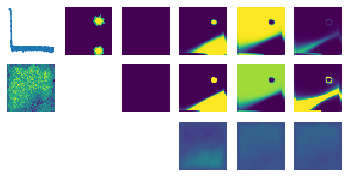

loss 10750 tensor(2.8547, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0068, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0068, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0068, device='cuda:1') >>><<


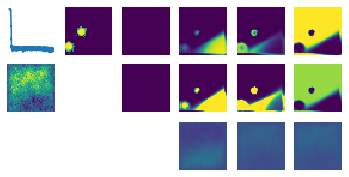

tensor(1.0000e-08, device='cuda:1') tensor(0.0081, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0081, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0081, device='cuda:1') >>><<


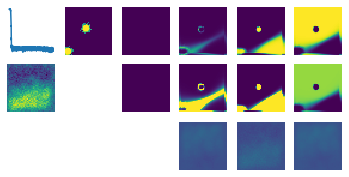

loss 11000 tensor(2.9548, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0219, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0219, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0219, device='cuda:1') >>><<


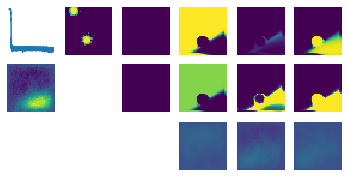

tensor(1.0000e-08, device='cuda:1') tensor(0.0212, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0212, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0212, device='cuda:1') >>><<


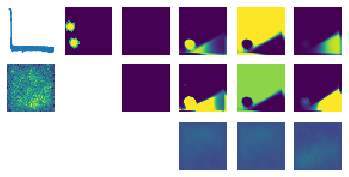

loss 11250 tensor(2.7115, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0182, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0182, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0182, device='cuda:1') >>><<


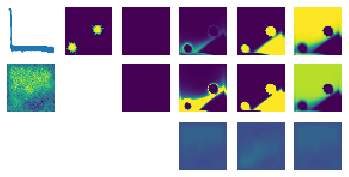

tensor(1.0000e-08, device='cuda:1') tensor(0.0242, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0242, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0242, device='cuda:1') >>><<


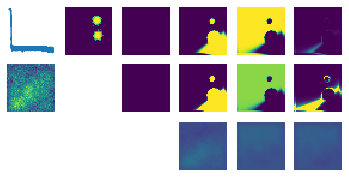

loss 11500 tensor(2.7648, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0249, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0249, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0249, device='cuda:1') >>><<


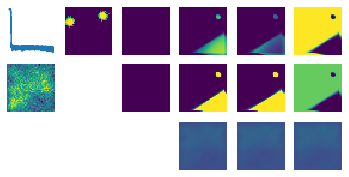

tensor(1.0000e-08, device='cuda:1') tensor(0.0233, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0233, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0233, device='cuda:1') >>><<


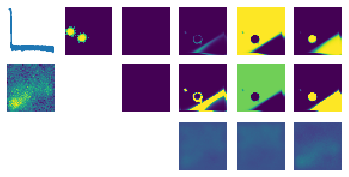

loss 11750 tensor(2.8502, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0297, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0297, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0297, device='cuda:1') >>><<


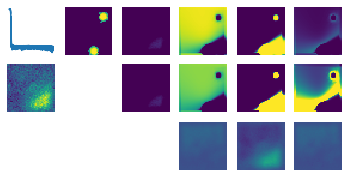

tensor(1.0000e-08, device='cuda:1') tensor(0.0415, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0415, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0415, device='cuda:1') >>><<


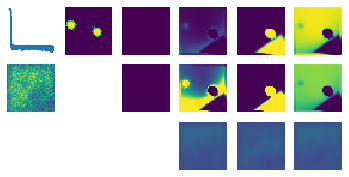

loss 12000 tensor(2.3776, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0244, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0244, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0244, device='cuda:1') >>><<


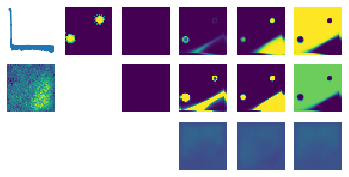

tensor(1.0000e-08, device='cuda:1') tensor(0.0280, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0280, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0280, device='cuda:1') >>><<


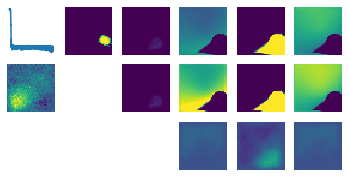

loss 12250 tensor(2.8165, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0203, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0203, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0203, device='cuda:1') >>><<


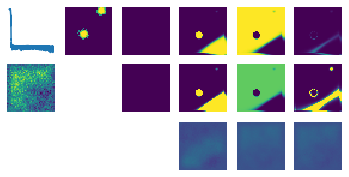

tensor(1.0000e-08, device='cuda:1') tensor(0.0254, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0254, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0254, device='cuda:1') >>><<


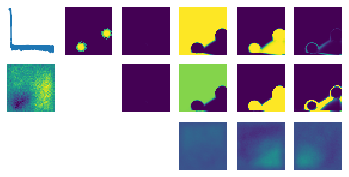

loss 12500 tensor(2.6845, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0237, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0237, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0237, device='cuda:1') >>><<


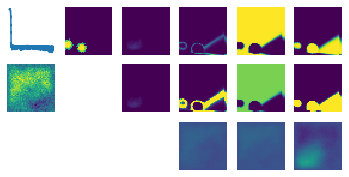

tensor(1.0000e-08, device='cuda:1') tensor(0.0225, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0225, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0225, device='cuda:1') >>><<


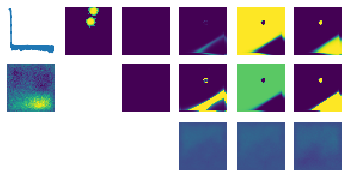

loss 12750 tensor(2.6617, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0205, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0205, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0205, device='cuda:1') >>><<


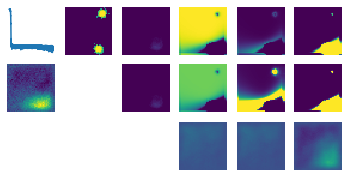

tensor(1.0000e-08, device='cuda:1') tensor(0.0325, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0325, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0325, device='cuda:1') >>><<


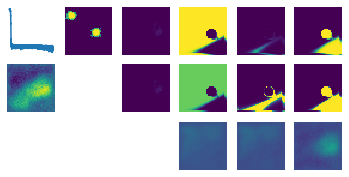

loss 13000 tensor(2.5811, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0282, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0282, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0282, device='cuda:1') >>><<


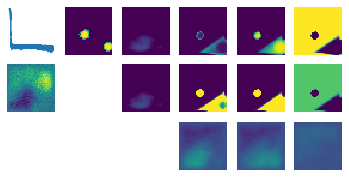

tensor(1.0000e-08, device='cuda:1') tensor(0.0263, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0263, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0263, device='cuda:1') >>><<


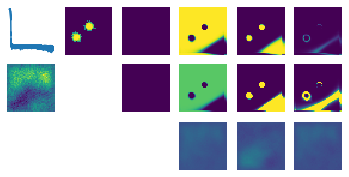

loss 13250 tensor(2.5931, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0166, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0166, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0166, device='cuda:1') >>><<


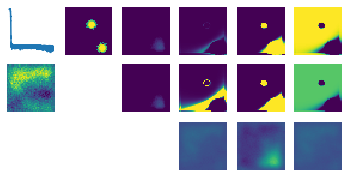

tensor(1.0000e-08, device='cuda:1') tensor(0.0247, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0247, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0247, device='cuda:1') >>><<


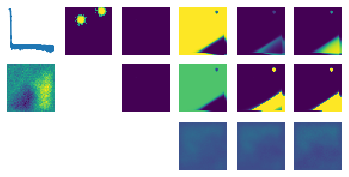

loss 13500 tensor(2.7344, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0209, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0209, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0209, device='cuda:1') >>><<


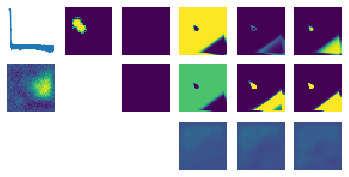

tensor(1.0000e-08, device='cuda:1') tensor(0.0219, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0219, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0219, device='cuda:1') >>><<


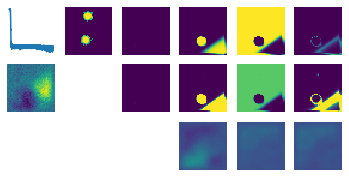

loss 13750 tensor(2.5512, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0112, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0112, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0112, device='cuda:1') >>><<


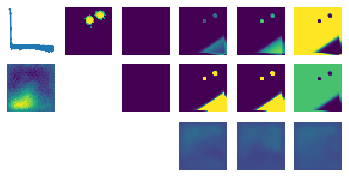

tensor(1.0000e-08, device='cuda:1') tensor(0.0183, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0183, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0183, device='cuda:1') >>><<


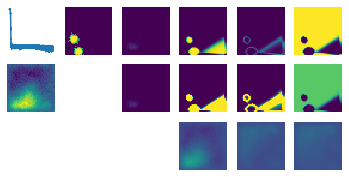

loss 14000 tensor(2.7156, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0288, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0288, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0288, device='cuda:1') >>><<


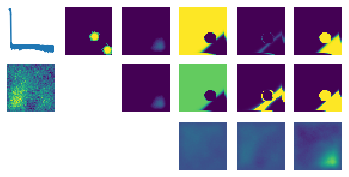

tensor(1.0000e-08, device='cuda:1') tensor(0.0248, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0248, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0248, device='cuda:1') >>><<


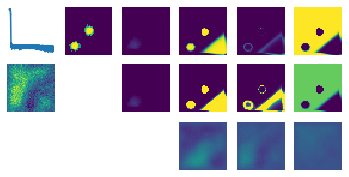

loss 14250 tensor(2.6394, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0140, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0140, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0140, device='cuda:1') >>><<


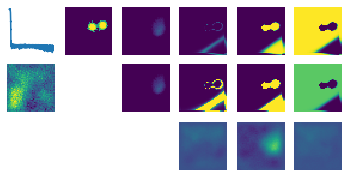

tensor(1.0000e-08, device='cuda:1') tensor(0.0194, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0194, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0194, device='cuda:1') >>><<


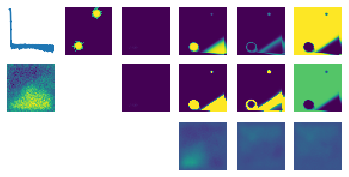

loss 14500 tensor(2.5553, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0245, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0245, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0245, device='cuda:1') >>><<


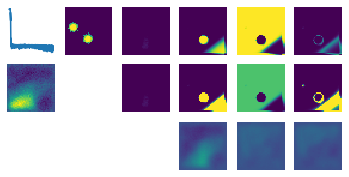

tensor(1.0000e-08, device='cuda:1') tensor(0.0210, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0210, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0210, device='cuda:1') >>><<


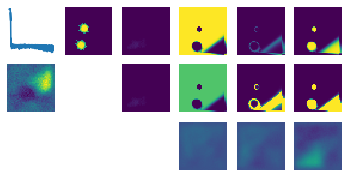

loss 14750 tensor(2.7865, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0196, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0196, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0196, device='cuda:1') >>><<


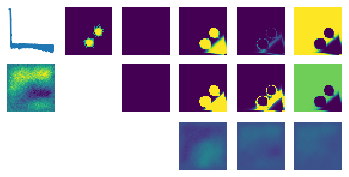

tensor(1.0000e-08, device='cuda:1') tensor(0.0186, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0186, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0186, device='cuda:1') >>><<


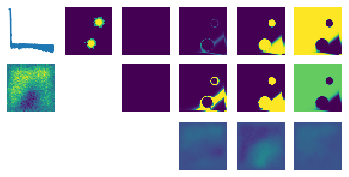

loss 15000 tensor(2.4942, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0250, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0250, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0250, device='cuda:1') >>><<


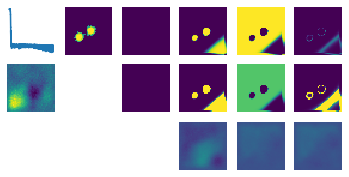

tensor(1.0000e-08, device='cuda:1') tensor(0.0167, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0167, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0167, device='cuda:1') >>><<


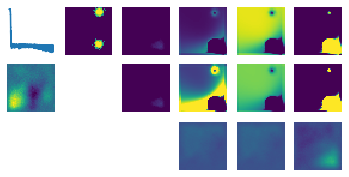

loss 15250 tensor(2.4057, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0138, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0138, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0138, device='cuda:1') >>><<


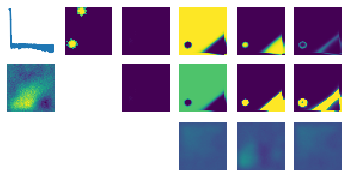

tensor(1.0000e-08, device='cuda:1') tensor(0.0131, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0131, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0131, device='cuda:1') >>><<


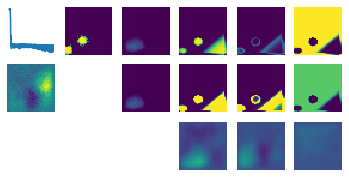

loss 15500 tensor(2.7151, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0174, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0174, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0174, device='cuda:1') >>><<


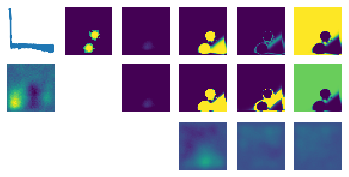

tensor(1.0000e-08, device='cuda:1') tensor(0.0163, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0163, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0163, device='cuda:1') >>><<


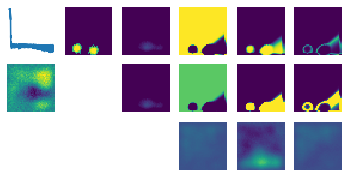

loss 15750 tensor(2.3960, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0231, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0231, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0231, device='cuda:1') >>><<


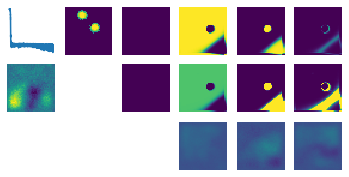

tensor(1.0000e-08, device='cuda:1') tensor(0.0234, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0234, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0234, device='cuda:1') >>><<


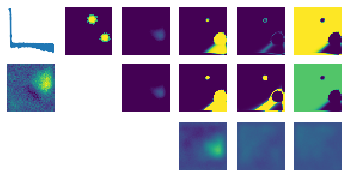

loss 16000 tensor(2.7165, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0285, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0285, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0285, device='cuda:1') >>><<


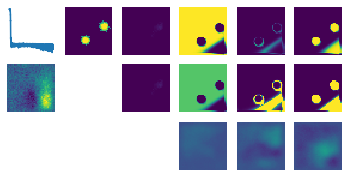

tensor(1.0000e-08, device='cuda:1') tensor(0.0249, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0249, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0249, device='cuda:1') >>><<


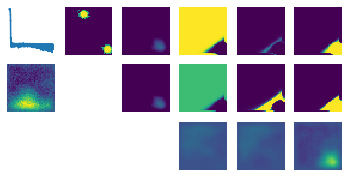

loss 16250 tensor(2.5927, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0230, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0230, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0230, device='cuda:1') >>><<


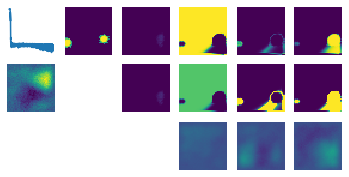

tensor(1.0000e-08, device='cuda:1') tensor(0.0172, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0172, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0172, device='cuda:1') >>><<


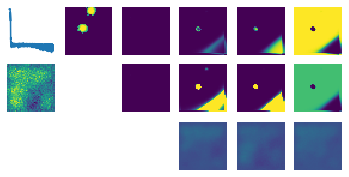

loss 16500 tensor(2.6539, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0485, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0485, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0485, device='cuda:1') >>><<


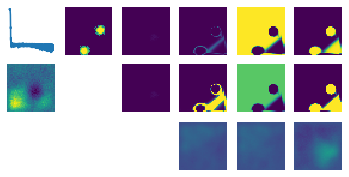

tensor(1.0000e-08, device='cuda:1') tensor(0.0427, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0427, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0427, device='cuda:1') >>><<


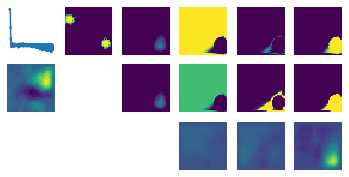

loss 16750 tensor(2.5233, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0203, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0203, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0203, device='cuda:1') >>><<


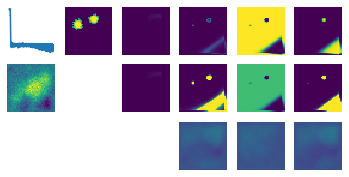

tensor(1.0000e-08, device='cuda:1') tensor(0.0151, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0151, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0151, device='cuda:1') >>><<


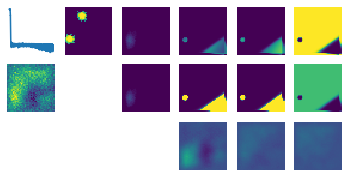

loss 17000 tensor(2.5013, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0580, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0580, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0580, device='cuda:1') >>><<


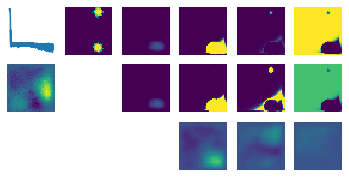

tensor(1.0000e-08, device='cuda:1') tensor(0.0539, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0539, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0539, device='cuda:1') >>><<


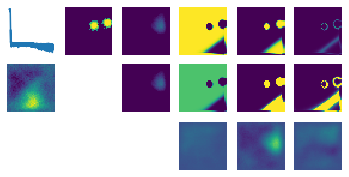

loss 17250 tensor(2.6036, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0314, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0314, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0314, device='cuda:1') >>><<


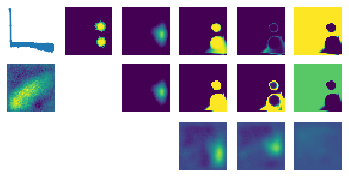

tensor(1.0000e-08, device='cuda:1') tensor(0.0545, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0545, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0545, device='cuda:1') >>><<


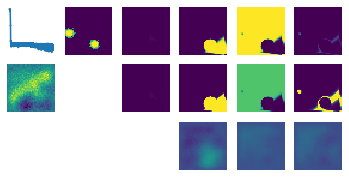

loss 17500 tensor(2.3036, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0182, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0182, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0182, device='cuda:1') >>><<


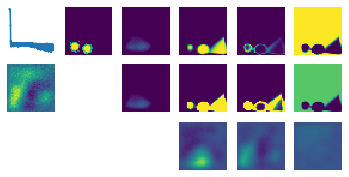

tensor(1.0000e-08, device='cuda:1') tensor(0.0190, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0190, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0190, device='cuda:1') >>><<


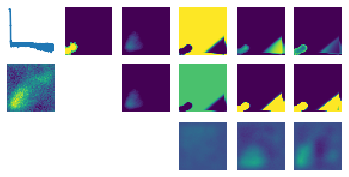

loss 17750 tensor(2.5176, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0462, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0462, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0462, device='cuda:1') >>><<


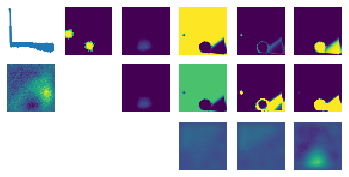

tensor(1.0000e-08, device='cuda:1') tensor(0.0331, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0331, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0331, device='cuda:1') >>><<


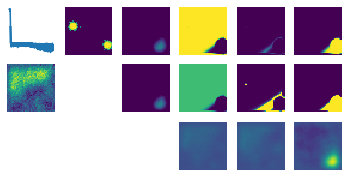

loss 18000 tensor(2.7869, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0224, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0224, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0224, device='cuda:1') >>><<


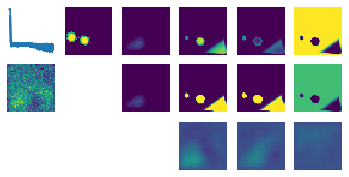

tensor(1.0000e-08, device='cuda:1') tensor(0.0505, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0505, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0505, device='cuda:1') >>><<


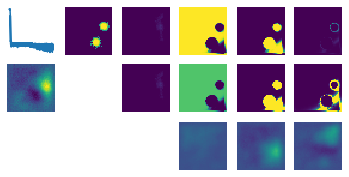

loss 18250 tensor(2.7439, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0209, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0209, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0209, device='cuda:1') >>><<


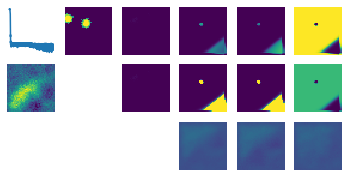

tensor(1.0000e-08, device='cuda:1') tensor(0.0264, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0264, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0264, device='cuda:1') >>><<


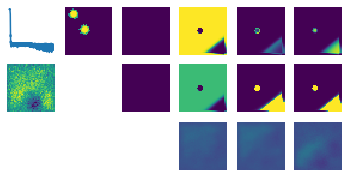

loss 18500 tensor(2.4947, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0332, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0332, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0332, device='cuda:1') >>><<


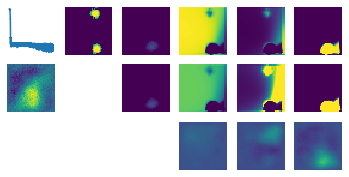

tensor(1.0000e-08, device='cuda:1') tensor(0.0545, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0545, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0545, device='cuda:1') >>><<


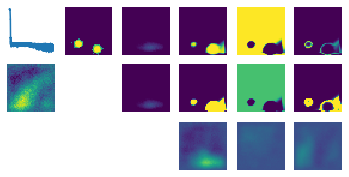

loss 18750 tensor(2.4950, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0136, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0136, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0136, device='cuda:1') >>><<


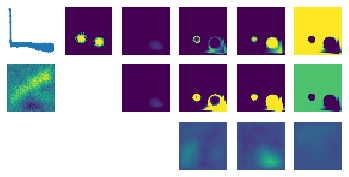

tensor(1.0000e-08, device='cuda:1') tensor(0.0212, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0212, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0212, device='cuda:1') >>><<


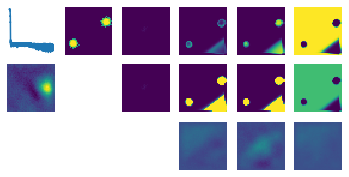

loss 19000 tensor(2.3943, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0333, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0333, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0333, device='cuda:1') >>><<


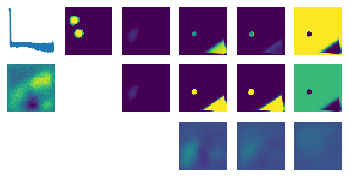

tensor(1.0000e-08, device='cuda:1') tensor(0.0372, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0372, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0372, device='cuda:1') >>><<


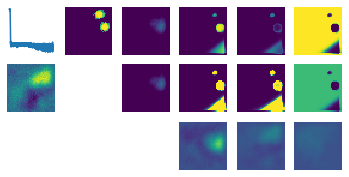

loss 19250 tensor(2.2475, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0553, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0553, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0553, device='cuda:1') >>><<


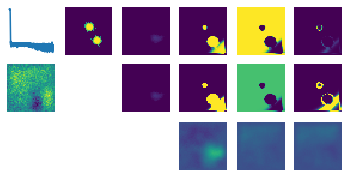

tensor(1.0000e-08, device='cuda:1') tensor(0.0736, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0736, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0736, device='cuda:1') >>><<


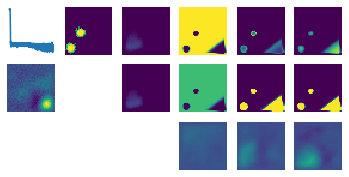

loss 19500 tensor(2.4797, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0208, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0208, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0208, device='cuda:1') >>><<


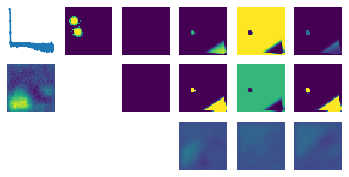

tensor(1.0000e-08, device='cuda:1') tensor(0.0383, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0383, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0383, device='cuda:1') >>><<


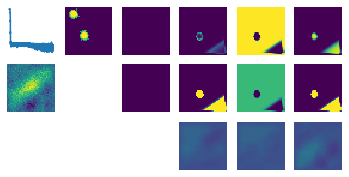

loss 19750 tensor(2.5369, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0364, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0364, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0364, device='cuda:1') >>><<


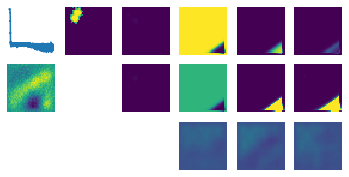

tensor(1.0000e-08, device='cuda:1') tensor(0.0271, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0271, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0271, device='cuda:1') >>><<


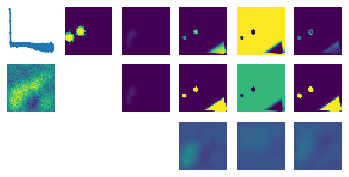

loss 20000 tensor(2.2640, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0317, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0317, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0317, device='cuda:1') >>><<


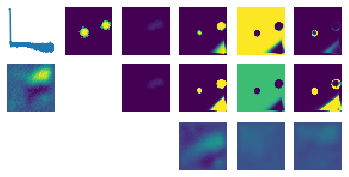

tensor(1.0000e-08, device='cuda:1') tensor(0.0397, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0397, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0397, device='cuda:1') >>><<


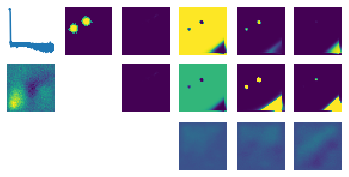

loss 20250 tensor(2.4001, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1053, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1053, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1053, device='cuda:1') >>><<


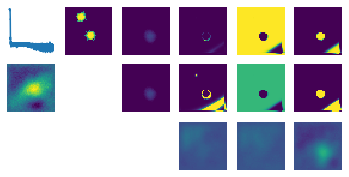

tensor(1.0000e-08, device='cuda:1') tensor(0.1044, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1044, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1044, device='cuda:1') >>><<


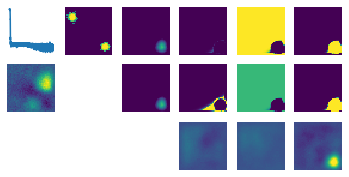

loss 20500 tensor(2.3996, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0544, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0544, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0544, device='cuda:1') >>><<


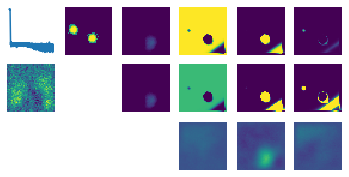

tensor(1.0000e-08, device='cuda:1') tensor(0.0469, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0469, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0469, device='cuda:1') >>><<


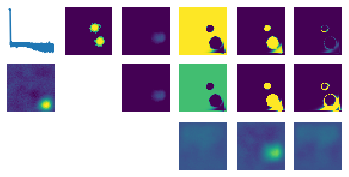

loss 20750 tensor(2.2015, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0489, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0489, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0489, device='cuda:1') >>><<


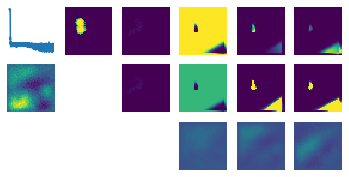

tensor(1.0000e-08, device='cuda:1') tensor(0.0624, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0624, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0624, device='cuda:1') >>><<


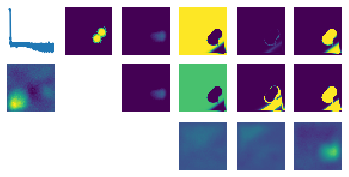

loss 21000 tensor(2.5389, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0912, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0912, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0912, device='cuda:1') >>><<


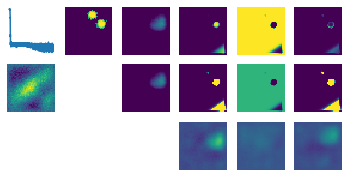

tensor(1.0000e-08, device='cuda:1') tensor(0.0856, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0856, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0856, device='cuda:1') >>><<


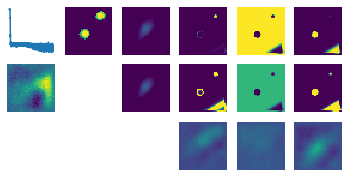

loss 21250 tensor(2.1678, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1104, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1104, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1104, device='cuda:1') >>><<


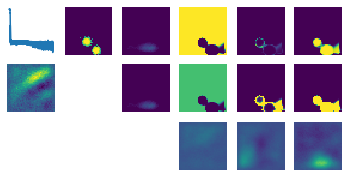

tensor(1.0000e-08, device='cuda:1') tensor(0.0669, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0669, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0669, device='cuda:1') >>><<


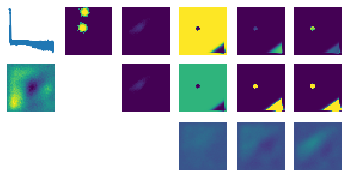

loss 21500 tensor(2.6953, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0551, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0551, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0551, device='cuda:1') >>><<


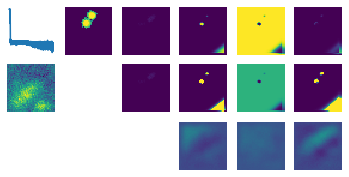

tensor(1.0000e-08, device='cuda:1') tensor(0.0706, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0706, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0706, device='cuda:1') >>><<


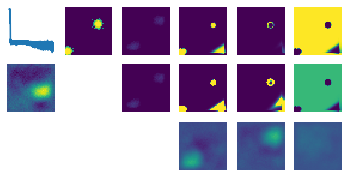

loss 21750 tensor(2.7807, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0691, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0691, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0691, device='cuda:1') >>><<


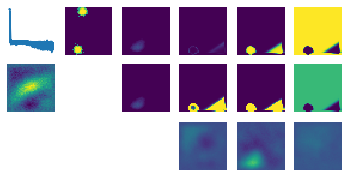

tensor(1.0000e-08, device='cuda:1') tensor(0.0386, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0386, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0386, device='cuda:1') >>><<


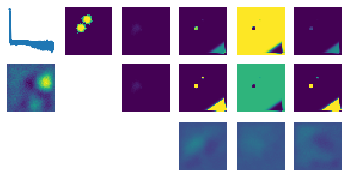

loss 22000 tensor(2.1832, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0553, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0553, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0553, device='cuda:1') >>><<


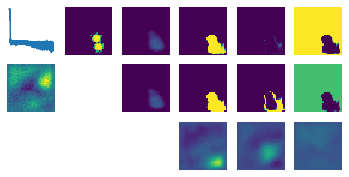

tensor(1.0000e-08, device='cuda:1') tensor(0.1777, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1777, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1777, device='cuda:1') >>><<


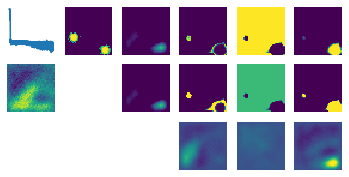

loss 22250 tensor(2.3778, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1528, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1528, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1528, device='cuda:1') >>><<


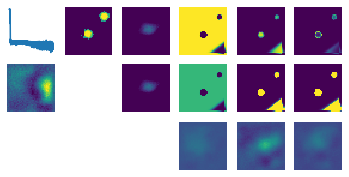

tensor(1.0000e-08, device='cuda:1') tensor(0.1484, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1484, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1484, device='cuda:1') >>><<


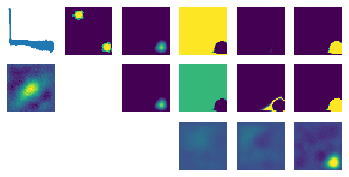

loss 22500 tensor(2.1170, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0901, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0901, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0901, device='cuda:1') >>><<


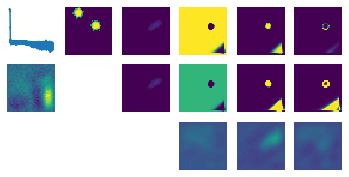

tensor(1.0000e-08, device='cuda:1') tensor(0.0516, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0516, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0516, device='cuda:1') >>><<


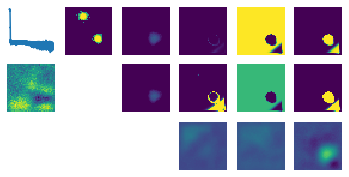

loss 22750 tensor(2.3074, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0397, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0397, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0397, device='cuda:1') >>><<


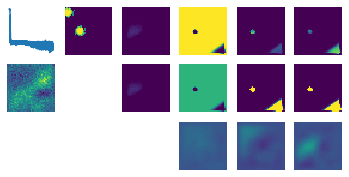

tensor(1.0000e-08, device='cuda:1') tensor(0.0340, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0340, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0340, device='cuda:1') >>><<


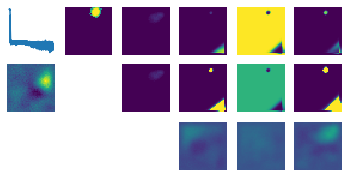

loss 23000 tensor(2.0233, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0543, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0543, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0543, device='cuda:1') >>><<


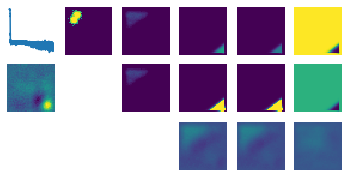

tensor(1.0000e-08, device='cuda:1') tensor(0.0488, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0488, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0488, device='cuda:1') >>><<


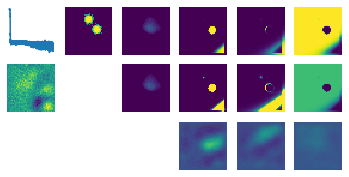

loss 23250 tensor(2.1833, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0686, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0686, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0686, device='cuda:1') >>><<


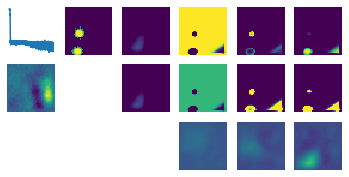

tensor(1.0000e-08, device='cuda:1') tensor(0.0646, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0646, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0646, device='cuda:1') >>><<


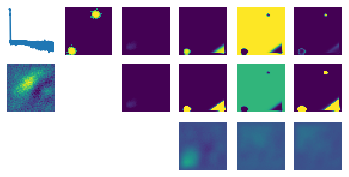

loss 23500 tensor(2.1745, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1085, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1085, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1085, device='cuda:1') >>><<


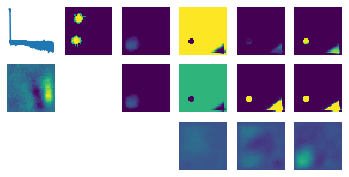

tensor(1.0000e-08, device='cuda:1') tensor(0.0417, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0417, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0417, device='cuda:1') >>><<


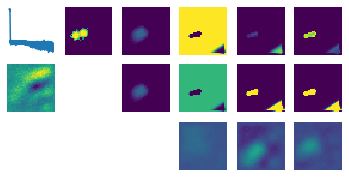

loss 23750 tensor(1.6858, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0686, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0686, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0686, device='cuda:1') >>><<


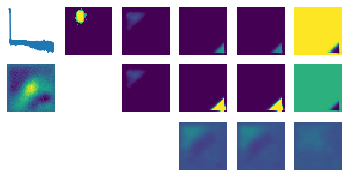

tensor(1.0000e-08, device='cuda:1') tensor(0.0685, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0685, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0685, device='cuda:1') >>><<


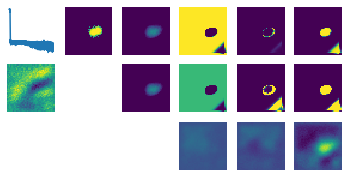

loss 24000 tensor(2.2739, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0608, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0608, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0608, device='cuda:1') >>><<


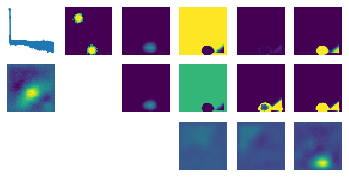

tensor(1.0000e-08, device='cuda:1') tensor(0.0769, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0769, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0769, device='cuda:1') >>><<


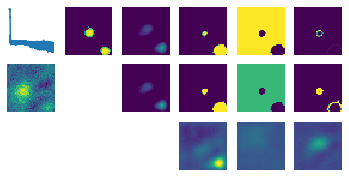

loss 24250 tensor(2.0011, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0644, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0644, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0644, device='cuda:1') >>><<


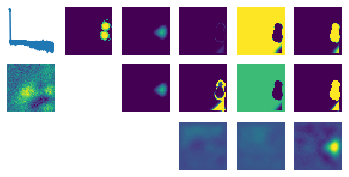

tensor(1.0000e-08, device='cuda:1') tensor(0.0559, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0559, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0559, device='cuda:1') >>><<


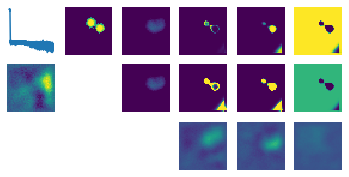

loss 24500 tensor(2.1313, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0603, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0603, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0603, device='cuda:1') >>><<


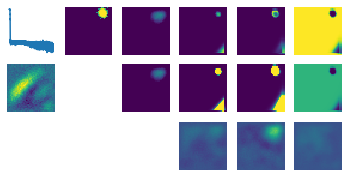

tensor(1.0000e-08, device='cuda:1') tensor(0.0678, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0678, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0678, device='cuda:1') >>><<


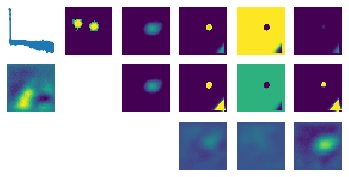

loss 24750 tensor(2.0903, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0593, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0593, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0593, device='cuda:1') >>><<


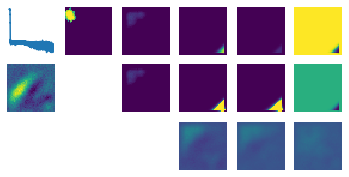

tensor(1.0000e-08, device='cuda:1') tensor(0.0977, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0977, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0977, device='cuda:1') >>><<


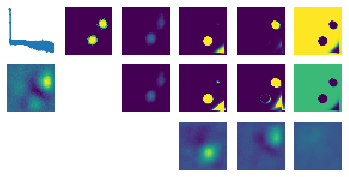

loss 25000 tensor(1.7808, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0726, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0726, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0726, device='cuda:1') >>><<


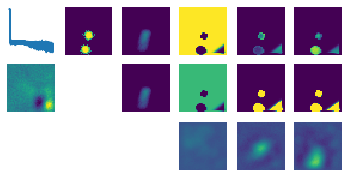

tensor(1.0000e-08, device='cuda:1') tensor(0.1176, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1176, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1176, device='cuda:1') >>><<


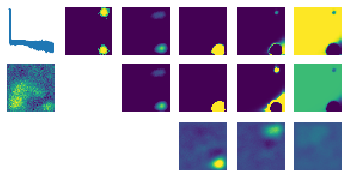

loss 25250 tensor(2.1798, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0566, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0566, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0566, device='cuda:1') >>><<


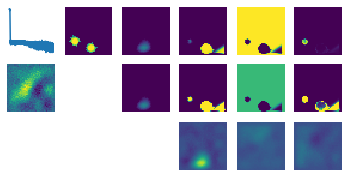

tensor(1.0000e-08, device='cuda:1') tensor(0.0617, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0617, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0617, device='cuda:1') >>><<


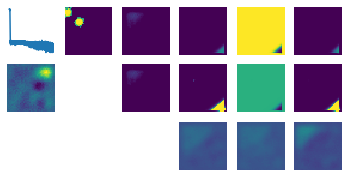

loss 25500 tensor(2.1371, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0821, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0821, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0821, device='cuda:1') >>><<


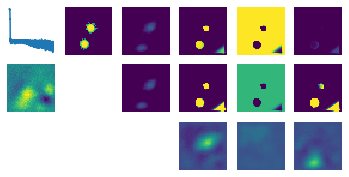

tensor(1.0000e-08, device='cuda:1') tensor(0.0655, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0655, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0655, device='cuda:1') >>><<


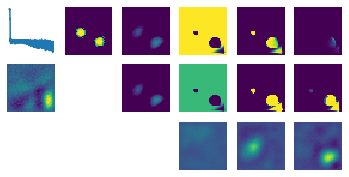

loss 25750 tensor(2.1369, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0566, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0566, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0566, device='cuda:1') >>><<


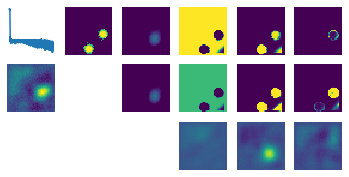

tensor(1.0000e-08, device='cuda:1') tensor(0.0813, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0813, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0813, device='cuda:1') >>><<


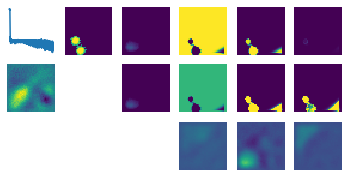

loss 26000 tensor(2.3609, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0528, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0528, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0528, device='cuda:1') >>><<


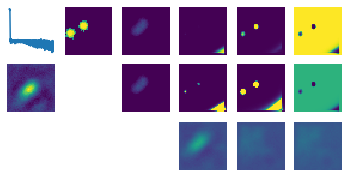

tensor(1.0000e-08, device='cuda:1') tensor(0.1407, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1407, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1407, device='cuda:1') >>><<


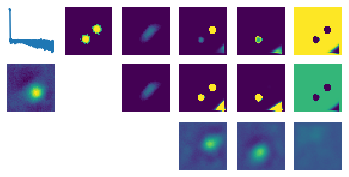

loss 26250 tensor(1.9950, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0876, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0876, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0876, device='cuda:1') >>><<


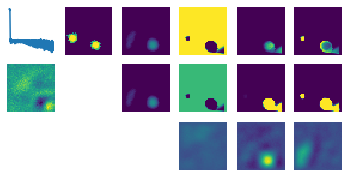

tensor(1.0000e-08, device='cuda:1') tensor(0.1251, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1251, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1251, device='cuda:1') >>><<


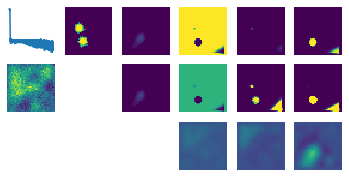

loss 26500 tensor(2.1310, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1724, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1724, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1724, device='cuda:1') >>><<


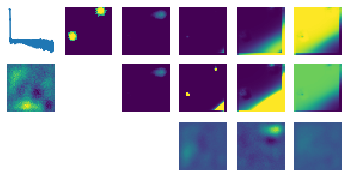

tensor(1.0000e-08, device='cuda:1') tensor(0.1358, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1358, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1358, device='cuda:1') >>><<


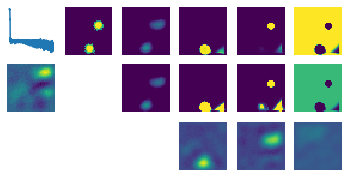

loss 26750 tensor(1.7998, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1002, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1002, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1002, device='cuda:1') >>><<


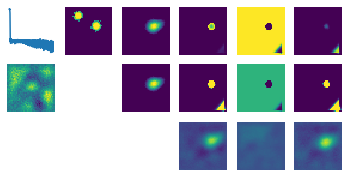

tensor(1.0000e-08, device='cuda:1') tensor(0.0923, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0923, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0923, device='cuda:1') >>><<


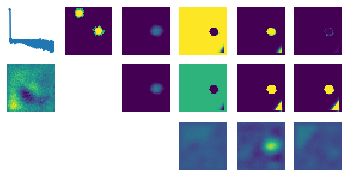

loss 27000 tensor(1.7592, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2734, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2734, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2734, device='cuda:1') >>><<


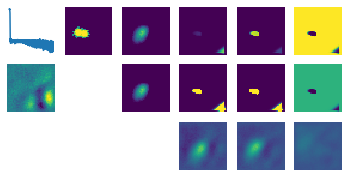

tensor(1.0000e-08, device='cuda:1') tensor(0.3185, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3185, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3185, device='cuda:1') >>><<


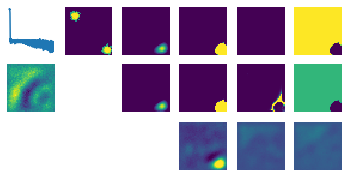

loss 27250 tensor(1.9943, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1572, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1572, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1572, device='cuda:1') >>><<


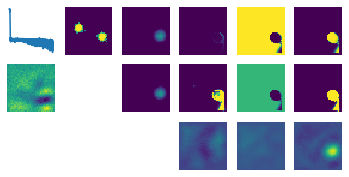

tensor(1.0000e-08, device='cuda:1') tensor(0.1851, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1851, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1851, device='cuda:1') >>><<


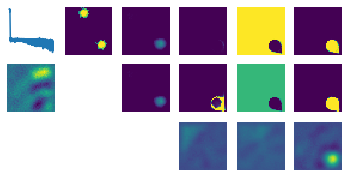

loss 27500 tensor(1.7732, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0623, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0623, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0623, device='cuda:1') >>><<


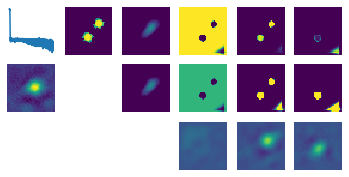

tensor(1.0000e-08, device='cuda:1') tensor(0.0662, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0662, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0662, device='cuda:1') >>><<


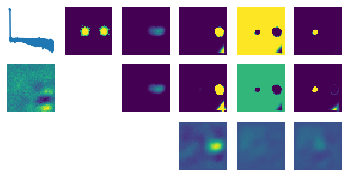

loss 27750 tensor(2.0844, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2654, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2654, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2654, device='cuda:1') >>><<


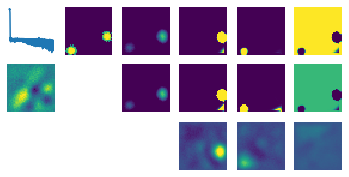

tensor(1.0000e-08, device='cuda:1') tensor(0.2326, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2326, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2326, device='cuda:1') >>><<


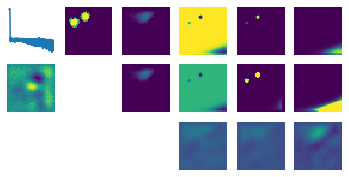

loss 28000 tensor(2.1712, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1195, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1195, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1195, device='cuda:1') >>><<


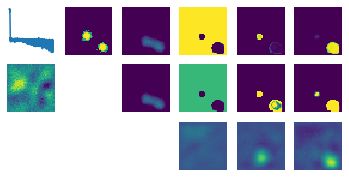

tensor(1.0000e-08, device='cuda:1') tensor(0.0509, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0509, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0509, device='cuda:1') >>><<


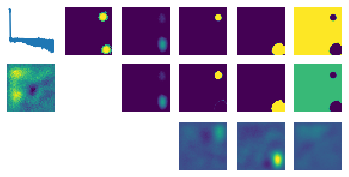

loss 28250 tensor(1.9694, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.5736, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5736, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5736, device='cuda:1') >>><<


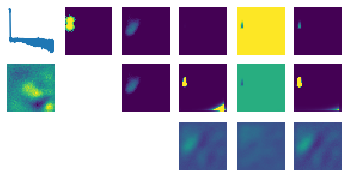

tensor(1.0000e-08, device='cuda:1') tensor(0.6051, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.6051, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.6051, device='cuda:1') >>><<


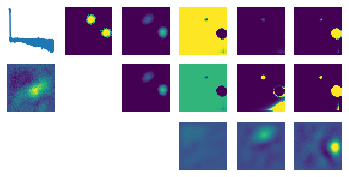

loss 28500 tensor(2.0132, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.3965, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3965, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3965, device='cuda:1') >>><<


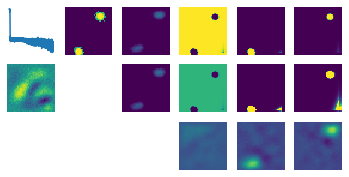

tensor(1.0000e-08, device='cuda:1') tensor(0.4153, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4153, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4153, device='cuda:1') >>><<


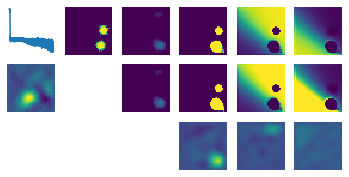

loss 28750 tensor(2.0420, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0974, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0974, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0974, device='cuda:1') >>><<


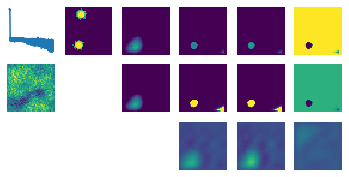

tensor(1.0000e-08, device='cuda:1') tensor(0.0434, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0434, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0434, device='cuda:1') >>><<


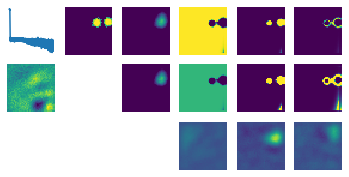

loss 29000 tensor(2.0508, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1023, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1023, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1023, device='cuda:1') >>><<


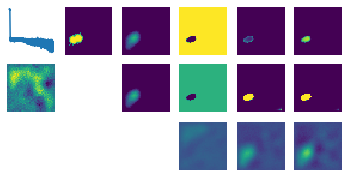

tensor(1.0000e-08, device='cuda:1') tensor(0.1073, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1073, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1073, device='cuda:1') >>><<


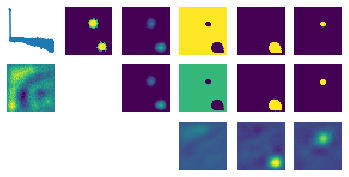

loss 29250 tensor(1.7325, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1480, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1480, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1480, device='cuda:1') >>><<


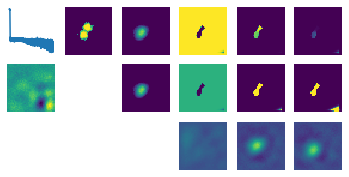

tensor(1.0000e-08, device='cuda:1') tensor(0.1787, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1787, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1787, device='cuda:1') >>><<


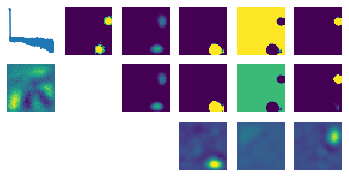

loss 29500 tensor(2.0042, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2038, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2038, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2038, device='cuda:1') >>><<


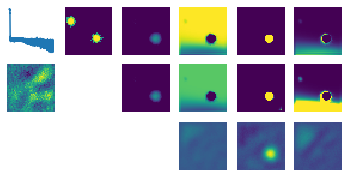

tensor(1.0000e-08, device='cuda:1') tensor(0.2797, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2797, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2797, device='cuda:1') >>><<


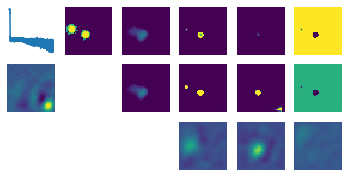

loss 29750 tensor(1.2948, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0428, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0428, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0428, device='cuda:1') >>><<


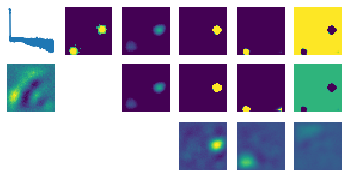

tensor(1.0000e-08, device='cuda:1') tensor(0.0730, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0730, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0730, device='cuda:1') >>><<


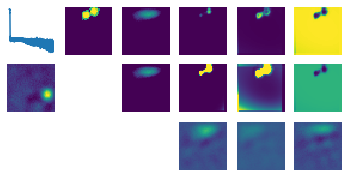

loss 30000 tensor(1.9383, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.3548, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3548, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3548, device='cuda:1') >>><<


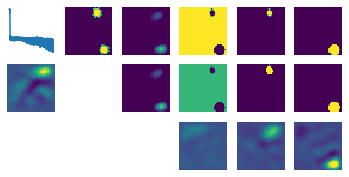

tensor(1.0000e-08, device='cuda:1') tensor(0.5252, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5252, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5252, device='cuda:1') >>><<


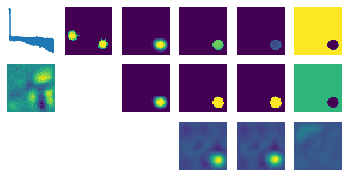

loss 30250 tensor(1.8905, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2176, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2176, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2176, device='cuda:1') >>><<


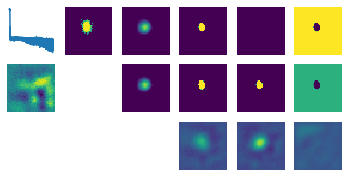

tensor(1.0000e-08, device='cuda:1') tensor(0.4683, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4683, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4683, device='cuda:1') >>><<


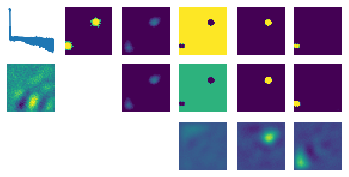

loss 30500 tensor(2.0569, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2934, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2934, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2934, device='cuda:1') >>><<


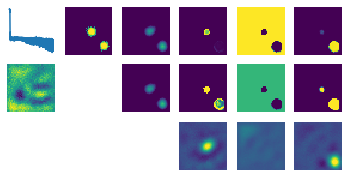

tensor(1.0000e-08, device='cuda:1') tensor(0.2194, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2194, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2194, device='cuda:1') >>><<


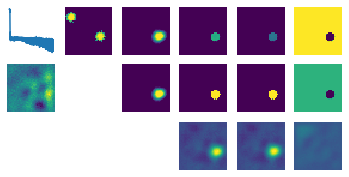

loss 30750 tensor(1.4542, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0536, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0536, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0536, device='cuda:1') >>><<


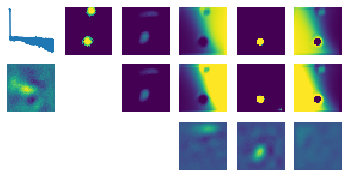

tensor(1.0000e-08, device='cuda:1') tensor(0.0956, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0956, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0956, device='cuda:1') >>><<


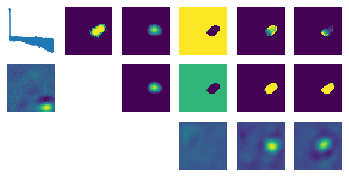

loss 31000 tensor(1.5598, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.3146, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3146, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3146, device='cuda:1') >>><<


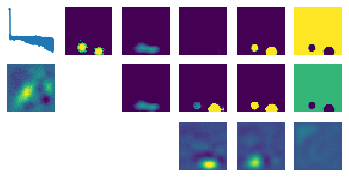

tensor(1.0000e-08, device='cuda:1') tensor(0.3471, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3471, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3471, device='cuda:1') >>><<


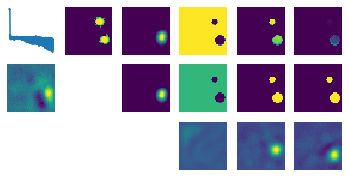

loss 31250 tensor(1.6468, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1536, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1536, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1536, device='cuda:1') >>><<


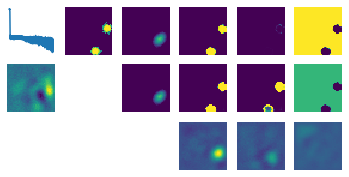

tensor(1.0000e-08, device='cuda:1') tensor(0.0649, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0649, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0649, device='cuda:1') >>><<


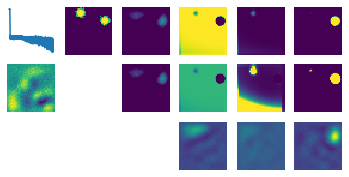

loss 31500 tensor(1.3774, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1330, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1330, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1330, device='cuda:1') >>><<


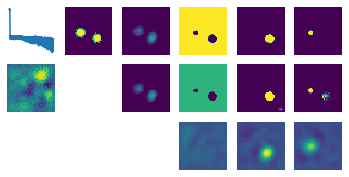

tensor(1.0000e-08, device='cuda:1') tensor(0.0984, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0984, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0984, device='cuda:1') >>><<


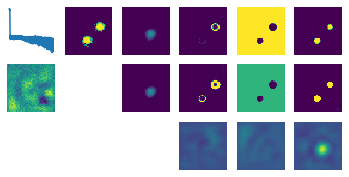

loss 31750 tensor(2.1674, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1983, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1983, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1983, device='cuda:1') >>><<


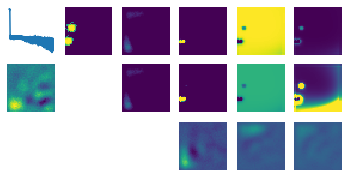

tensor(1.0000e-08, device='cuda:1') tensor(0.2469, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2469, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2469, device='cuda:1') >>><<


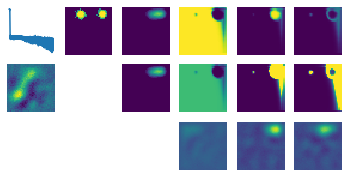

loss 32000 tensor(1.4808, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1241, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1241, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1241, device='cuda:1') >>><<


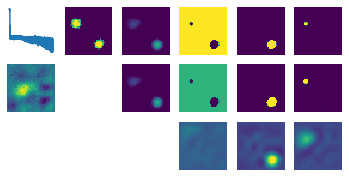

tensor(1.0000e-08, device='cuda:1') tensor(0.1731, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1731, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1731, device='cuda:1') >>><<


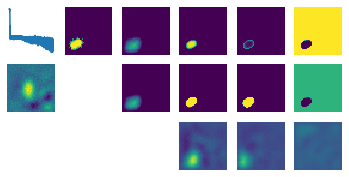

loss 32250 tensor(1.9574, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2261, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2261, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2261, device='cuda:1') >>><<


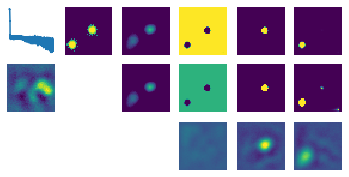

tensor(1.0000e-08, device='cuda:1') tensor(0.1232, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1232, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1232, device='cuda:1') >>><<


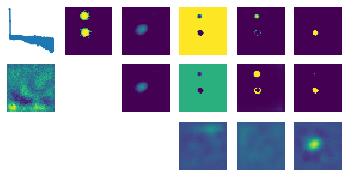

loss 32500 tensor(1.7229, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1422, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1422, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1422, device='cuda:1') >>><<


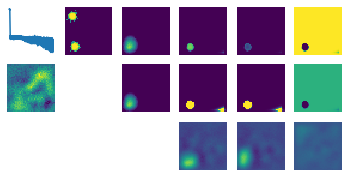

tensor(1.0000e-08, device='cuda:1') tensor(0.0707, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0707, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0707, device='cuda:1') >>><<


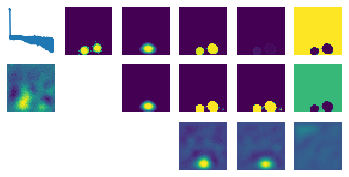

loss 32750 tensor(1.2698, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0916, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0916, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0916, device='cuda:1') >>><<


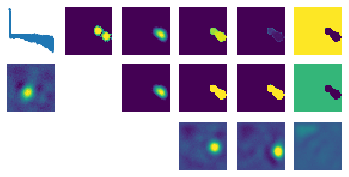

tensor(1.0000e-08, device='cuda:1') tensor(0.2021, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2021, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2021, device='cuda:1') >>><<


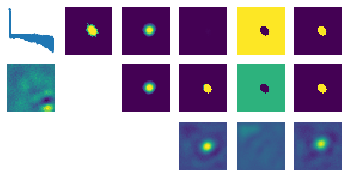

loss 33000 tensor(1.5935, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1356, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1356, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1356, device='cuda:1') >>><<


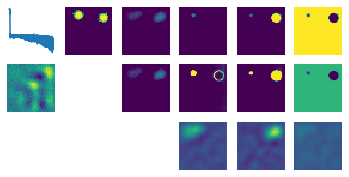

tensor(1.0000e-08, device='cuda:1') tensor(0.1537, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1537, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1537, device='cuda:1') >>><<


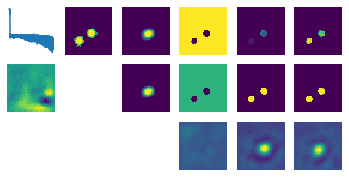

loss 33250 tensor(1.9178, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2096, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2096, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2096, device='cuda:1') >>><<


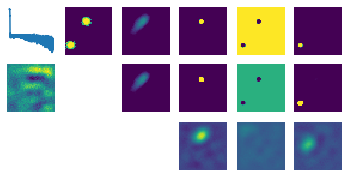

tensor(1.0000e-08, device='cuda:1') tensor(0.1813, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1813, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1813, device='cuda:1') >>><<


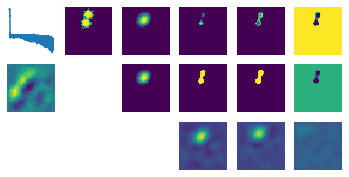

loss 33500 tensor(1.8438, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.3589, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3589, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3589, device='cuda:1') >>><<


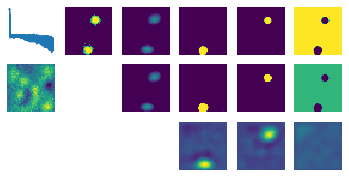

tensor(1.0000e-08, device='cuda:1') tensor(0.2934, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2934, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2934, device='cuda:1') >>><<


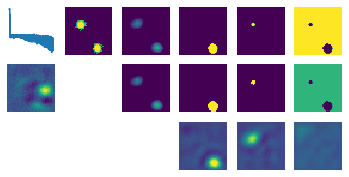

loss 33750 tensor(1.6718, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2744, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2744, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2744, device='cuda:1') >>><<


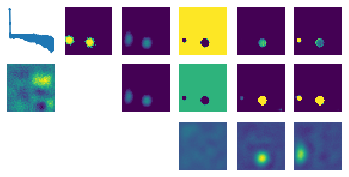

tensor(1.0000e-08, device='cuda:1') tensor(0.2279, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2279, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2279, device='cuda:1') >>><<


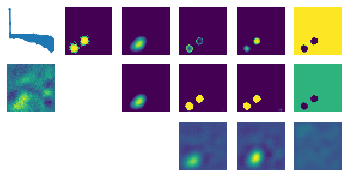

loss 34000 tensor(1.1916, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.5333, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5333, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5333, device='cuda:1') >>><<


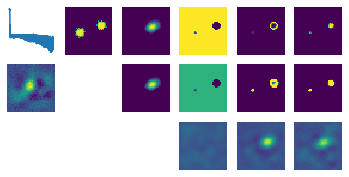

tensor(1.0000e-08, device='cuda:1') tensor(0.5863, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5863, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5863, device='cuda:1') >>><<


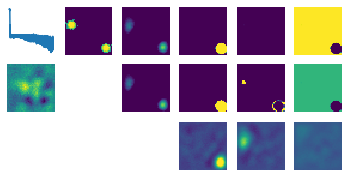

loss 34250 tensor(1.6207, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.4106, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4106, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4106, device='cuda:1') >>><<


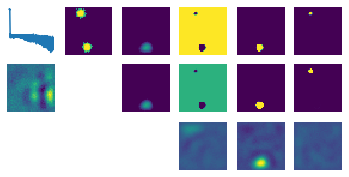

tensor(1.0000e-08, device='cuda:1') tensor(0.4228, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4228, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4228, device='cuda:1') >>><<


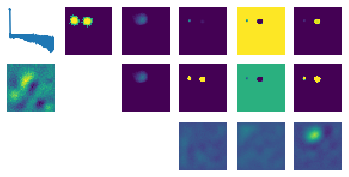

loss 34500 tensor(1.6017, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.5656, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5656, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5656, device='cuda:1') >>><<


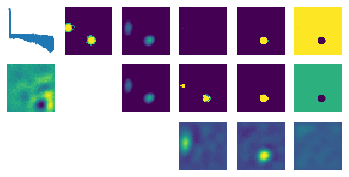

tensor(1.0000e-08, device='cuda:1') tensor(0.5512, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5512, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.5512, device='cuda:1') >>><<


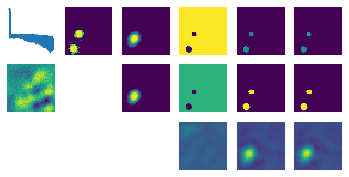

loss 34750 tensor(1.4256, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1068, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1068, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1068, device='cuda:1') >>><<


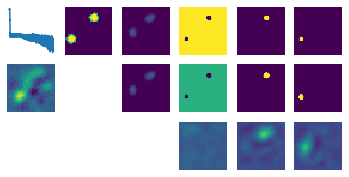

tensor(1.0000e-08, device='cuda:1') tensor(0.1230, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1230, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1230, device='cuda:1') >>><<


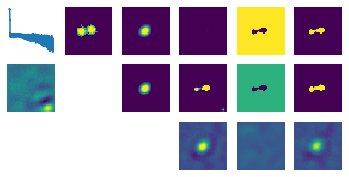

loss 35000 tensor(1.7152, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1103, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1103, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1103, device='cuda:1') >>><<


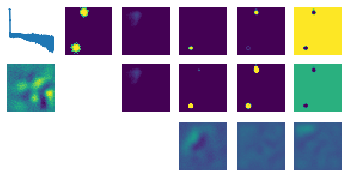

tensor(1.0000e-08, device='cuda:1') tensor(0.0884, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0884, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0884, device='cuda:1') >>><<


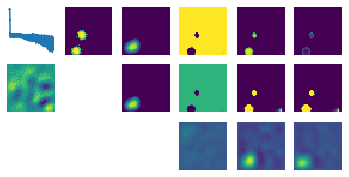

loss 35250 tensor(1.9620, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1940, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1940, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1940, device='cuda:1') >>><<


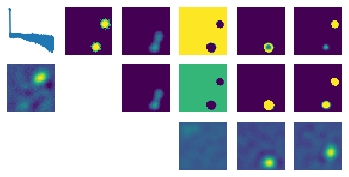

tensor(1.0000e-08, device='cuda:1') tensor(0.1419, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1419, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1419, device='cuda:1') >>><<


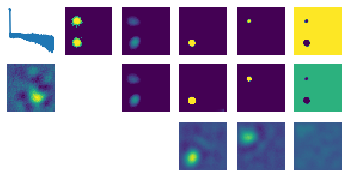

loss 35500 tensor(1.3962, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1487, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1487, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1487, device='cuda:1') >>><<


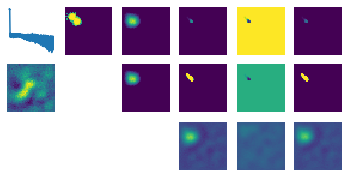

tensor(1.0000e-08, device='cuda:1') tensor(0.1811, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1811, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1811, device='cuda:1') >>><<


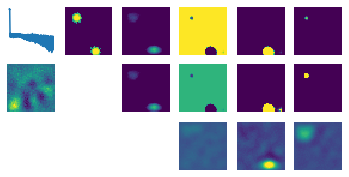

loss 35750 tensor(1.5172, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0708, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0708, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0708, device='cuda:1') >>><<


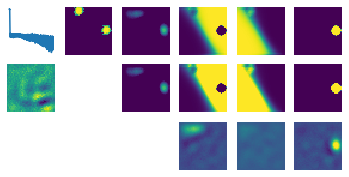

tensor(1.0000e-08, device='cuda:1') tensor(0.0556, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0556, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0556, device='cuda:1') >>><<


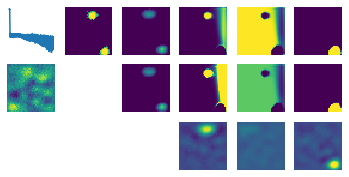

loss 36000 tensor(1.5382, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.4197, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4197, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.4197, device='cuda:1') >>><<


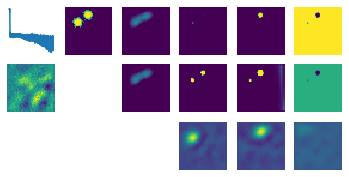

tensor(1.0000e-08, device='cuda:1') tensor(0.3368, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3368, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3368, device='cuda:1') >>><<


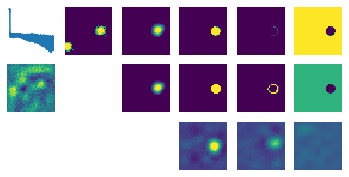

loss 36250 tensor(1.2736, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2149, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2149, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2149, device='cuda:1') >>><<


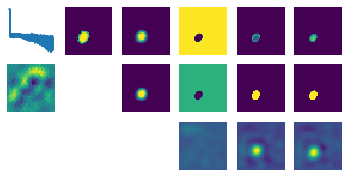

tensor(1.0000e-08, device='cuda:1') tensor(0.0529, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0529, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0529, device='cuda:1') >>><<


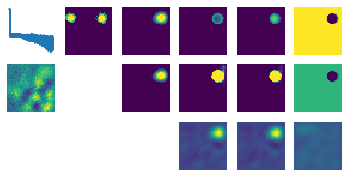

loss 36500 tensor(1.6359, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0829, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0829, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0829, device='cuda:1') >>><<


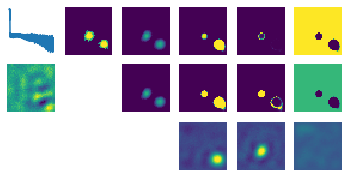

tensor(1.0000e-08, device='cuda:1') tensor(0.2125, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2125, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2125, device='cuda:1') >>><<


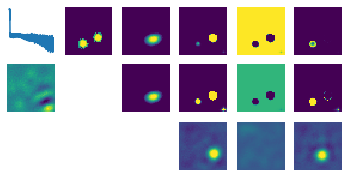

loss 36750 tensor(1.1165, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2991, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2991, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2991, device='cuda:1') >>><<


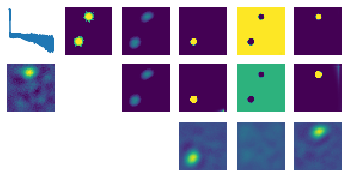

tensor(1.0000e-08, device='cuda:1') tensor(0.0949, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0949, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0949, device='cuda:1') >>><<


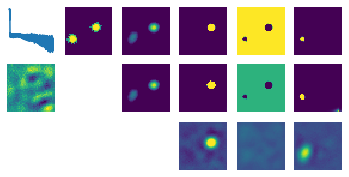

loss 37000 tensor(1.4782, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1541, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1541, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1541, device='cuda:1') >>><<


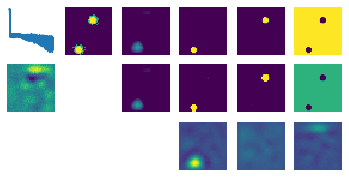

tensor(1.0000e-08, device='cuda:1') tensor(0.2450, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2450, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2450, device='cuda:1') >>><<


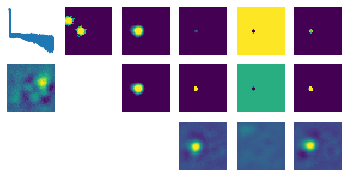

loss 37250 tensor(1.3117, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0561, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0561, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0561, device='cuda:1') >>><<


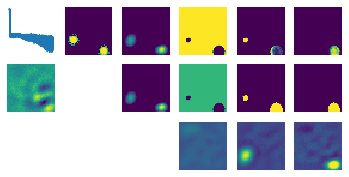

tensor(1.0000e-08, device='cuda:1') tensor(0.0743, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0743, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0743, device='cuda:1') >>><<


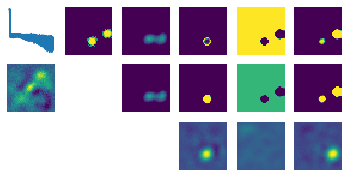

loss 37500 tensor(1.3161, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1835, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1835, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1835, device='cuda:1') >>><<


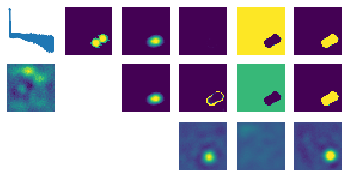

tensor(1.0000e-08, device='cuda:1') tensor(0.3884, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3884, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3884, device='cuda:1') >>><<


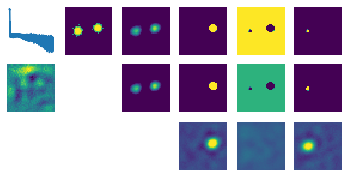

loss 37750 tensor(1.4550, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1688, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1688, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1688, device='cuda:1') >>><<


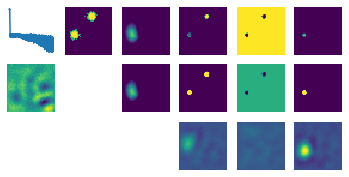

tensor(1.0000e-08, device='cuda:1') tensor(0.1542, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1542, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1542, device='cuda:1') >>><<


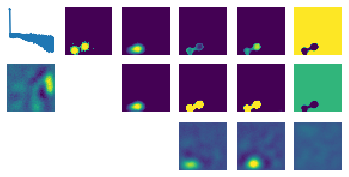

loss 38000 tensor(1.4168, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1627, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1627, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1627, device='cuda:1') >>><<


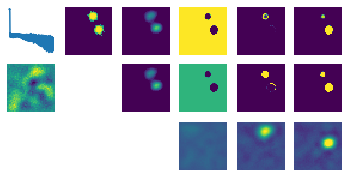

tensor(1.0000e-08, device='cuda:1') tensor(0.1863, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1863, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1863, device='cuda:1') >>><<


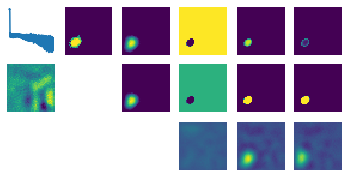

loss 38250 tensor(1.6238, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.3817, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3817, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3817, device='cuda:1') >>><<


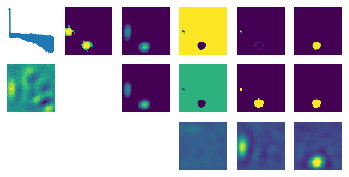

tensor(1.0000e-08, device='cuda:1') tensor(0.3094, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3094, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3094, device='cuda:1') >>><<


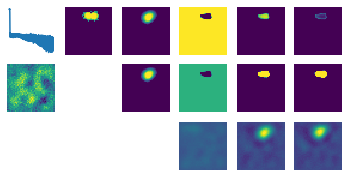

loss 38500 tensor(1.4080, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.3093, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3093, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.3093, device='cuda:1') >>><<


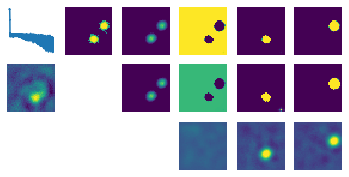

tensor(1.0000e-08, device='cuda:1') tensor(0.1053, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1053, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1053, device='cuda:1') >>><<


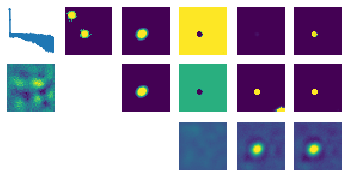

loss 38750 tensor(1.1961, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.1026, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1026, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1026, device='cuda:1') >>><<


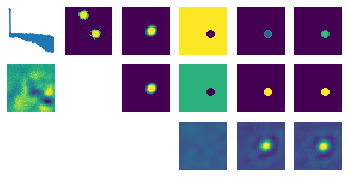

tensor(1.0000e-08, device='cuda:1') tensor(0.1338, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1338, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.1338, device='cuda:1') >>><<


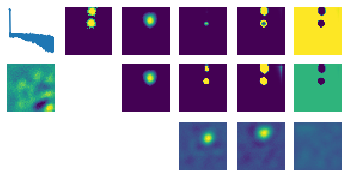

loss 39000 tensor(1.3195, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2661, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2661, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2661, device='cuda:1') >>><<


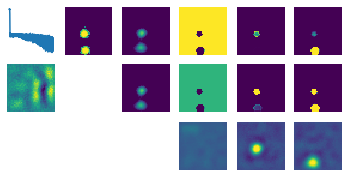

tensor(1.0000e-08, device='cuda:1') tensor(0.2592, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2592, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2592, device='cuda:1') >>><<


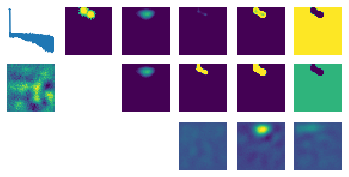

loss 39250 tensor(1.0342, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.2573, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2573, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2573, device='cuda:1') >>><<


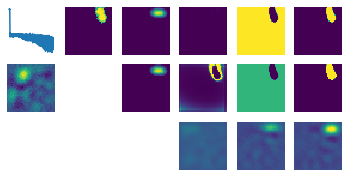

tensor(1.0000e-08, device='cuda:1') tensor(0.2714, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2714, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2714, device='cuda:1') >>><<


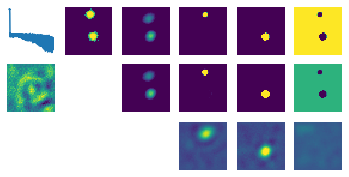

loss 39500 tensor(1.3371, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0980, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0980, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0980, device='cuda:1') >>><<


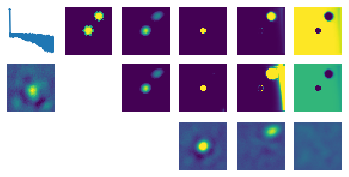

tensor(1.0000e-08, device='cuda:1') tensor(0.2039, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2039, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.2039, device='cuda:1') >>><<


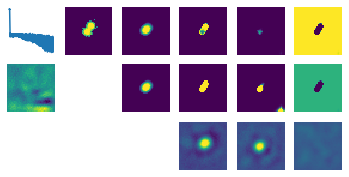

loss 39750 tensor(1.3963, device='cuda:1', grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08, device='cuda:1') tensor(0.0989, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0989, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0989, device='cuda:1') >>><<


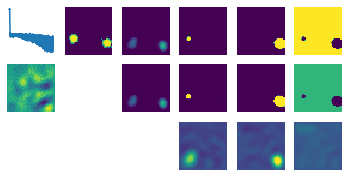

tensor(1.0000e-08, device='cuda:1') tensor(0.0796, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0796, device='cuda:1') >>><<
tensor(1.0000e-08, device='cuda:1') tensor(0.0796, device='cuda:1') >>><<


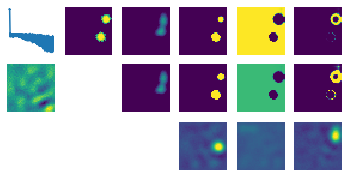

In [ ]:
model = AttModel().to(device)
model,*_rest = train(model,40_000)

In [658]:
# all-track fit :  is it a compromise just to make 

In [ ]:
!